Problem 24 from the advent of code calendar 2022.

January 6, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal


np.set_printoptions(linewidth=250, suppress=True)

In [2]:
#Writing the test input grid.  Will process this for now.

gtest = ['#.######',
'#>>.<^<#',
'#.<..<<#',
'#>v.><>#',
'#<^v^^>#',
'######.#']

with open("24.txt") as f:
    contents = f.readlines()

#It is important that the ROLL_PARAMETERS MATCH the SYMBOLS in the same location
SYMBOLS = ['>','<','^','v']
ROLL_PARAMETERS = [[1,1],[-1,1],[-1,0],[1,0]]
BASE = 10


#directions
N = np.array([0,-1])
S = np.array([0,1])
E = np.array([1,0])
W = np.array([-1,0])

DIRECTIONS = [N,S,W,E]



In [3]:
class Storms():
    
    def __init__(self, input_lines, verbose = False):
        
        self.blizzards = self.get_blizzards(input_lines,verbose = verbose)
 
    
    
    ###
    # Input processing framework
    ###
    def process_line(self,l):
        if l.count('#') > 2:
            return 'edge'
        else:
            l = l.rstrip()
            return l[1:-1]
    
    def process_grid(self, g):
        out = []
        for l in g:
            if self.process_line(l)!= 'edge':
                p = np.array(list(self.process_line(l)))
                out.append(p)
        return np.array(out)
    
    def get_blizzards(self, grid,verbose = False):

        g = self.process_grid(grid)
        if verbose:
            print(g)
        blizzards = []
        for i in range(len(SYMBOLS)):
            b = np.zeros(g.shape)
            b[g == SYMBOLS[i]] = BASE**i
            blizzards.append(b)
        return blizzards


    ###
    # Visualization 
    ###
    
    def __repr__(self):
        return str(self.blizzards)
    
    
    def symbol_grid(self):
        siq = self.combine_blizzards() 
        pin = np.array([['*' for i in range(siq.shape[1])] for j in range(siq.shape[0])])
        pin = siq.astype(np.str_)
        for i in range(len(SYMBOLS)):
            pin[np.where(siq == BASE**i)] = SYMBOLS[i]
        pin[np.where(siq == 0)] = '.'
        return pin
    
    
    ###
    # Roll the blizzards
    ###
    
    def roll_blizzards(self):
        for i in range(len(SYMBOLS)):
            self.blizzards[i] = np.roll(self.blizzards[i],*ROLL_PARAMETERS[i])
        return None
    

    

    ###
    # Basic operations
    ###
    def combine_blizzards(self):
        return np.array(self.blizzards).sum(axis = 0) 
    
    def possible_moves(self,location):
        """
        return which of locations are available in the current blizzard giving a previous location of 
        location.  Note that we can stay or move one square in any of the axis directions.

        """
                
        def eval_coords(x,y,grid):
            rval = 12345678
            if x in range(grid.shape[0]):
                if y in range(grid.shape[1]):
                    if grid[x,y] == 0:
                        rval =  0
            return rval
        
        
        x,y = location
        poss = []
        siq = self.combine_blizzards()
        if eval_coords(x,y,siq) == 0:
            poss.append(np.array(location))
        for delta in DIRECTIONS:
            x = location[0] + delta[0]
            y = location[1] + delta[1]
            if eval_coords(x,y,siq) == 0:
                poss.append(np.array([x,y]))
        return poss
    
    
    def possible_locations(self,grid):
        """
        Input:
            grid      A numpy array of the same size as the blizzards arrays consisting of zeros and 1s where 
                      each 1 corresponds to a position that an Elf could have been in in the minute prior to 
                      the current blizzard state.  Additionally we assume that an Elf could have been waiting 
                      at [0,-1]
            new       A numpy array the same size as grid listing all locations an elf could be at under the 
                      assumption they were at a 1 position or [0,-1] in the previous minute and moved at the 
                      same time as the blizzard went into the current configuration.
        """
        assert (grid.shape == self.blizzards[0].shape)
        assert (grid.max() <= 1)
        assert (grid.min() >= 0)        
                
        #Add in the locations from [0,-1]
        nlocs = self.possible_moves([0,-1])
        
        #Extend nlocs to include all of the positive locations in grid
        for x,y in zip(*np.where(grid > 0)):
            s = self.possible_moves([x,y])
            nlocs.extend(s)
        #print(nlocs)
        
        new = np.zeros_like(grid)
        #Go through and put ones in new at the nlocs positions
        for pair in nlocs:
            new[pair[0],pair[1]] = 1
        return new
        
    def time_through_storm(self, plots = False):
        
        minutes = 0
        track = np.zeros_like(self.blizzards[0])
        MAX_ITERS = 5000
        
        while (track[-1,-1] == 0) and (minutes < MAX_ITERS):
            self.roll_blizzards()
            track = self.possible_locations(track)
            minutes = minutes + 1
            if plots:
                a = self.combine_blizzards()
                for i in range(len(SYMBOLS)):
                    a[a==BASE**i] = i+1
                a[a>BASE] = len(SYMBOLS) 
                #sns.heatmap(a - track)
                #print(a-track)
                ax = sns.heatmap(track,cbar = False,square = True)
                ax.set_title('Minute {}'.format(minutes))
                plt.show()
        return minutes + 1 #Because we still need to step out of the grid.
    
    ###
    # For part II we need to add in the option of going backwards
    ###
    
    
    
    def backwards_possible_locations(self,grid):
        """
        Input:
            grid      A numpy array of the same size as the blizzards arrays consisting of zeros and 1s where 
                      each 1 corresponds to a position that an Elf could have been in in the minute prior to 
                      the current blizzard state.  Additionally we assume that an Elf could have been waiting 
                      at [0,-1]
            new       A numpy array the same size as grid listing all locations an elf could be at under the 
                      assumption they were at a 1 position or [0,-1] in the previous minute and moved at the 
                      same time as the blizzard went into the current configuration.
        """
        assert (grid.shape == self.blizzards[0].shape)
        assert (grid.max() <= 1)
        assert (grid.min() >= 0)        
                
        #Add in the locations from end
        end = grid.shape
        x = end[0] - 1
        y = end[1]
        nlocs = self.possible_moves([x,y])
        
        #Extend nlocs to include all of the positive locations in grid
        for x,y in zip(*np.where(grid > 0)):
            s = self.possible_moves([x,y])
            nlocs.extend(s)
        #print(nlocs)
        
        new = np.zeros_like(grid)
        #Go through and put ones in new at the nlocs positions
        for pair in nlocs:
            new[pair[0],pair[1]] = 1
        return new
        
    def backwards_time_through_storm(self, plots = False):
        
        minutes = 0
        track = np.zeros_like(self.blizzards[0])
        MAX_ITERS = 5000

        
        while (track[0,0] == 0) and (minutes < MAX_ITERS):
            self.roll_blizzards()
            track = self.backwards_possible_locations(track)
            minutes = minutes + 1
            
            if plots:
                a = self.combine_blizzards()
                for i in range(len(SYMBOLS)):
                    a[a==BASE**i] = i+1
                a[a>BASE] = len(SYMBOLS) 
                #sns.heatmap(a - track)
                #print(a-track)
                ax = sns.heatmap(track,cbar = False,square = True)
                ax.set_title('Minute {}'.format(minutes))
                plt.show()
        return minutes + 1 #Because we still need to step out of the grid.
        
      

In [4]:
g = Storms(gtest,verbose = True)

[['>' '>' '.' '<' '^' '<']
 ['.' '<' '.' '.' '<' '<']
 ['>' 'v' '.' '>' '<' '>']
 ['<' '^' 'v' '^' '^' '>']]


In [5]:
tcell = np.zeros_like(g.blizzards[0])
print(g.backwards_possible_locations(tcell))
g.roll_blizzards()
print(g.backwards_possible_locations(tcell))
g.roll_blizzards()
print(g.backwards_possible_locations(tcell))


[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [6]:
g = Storms(gtest,verbose = True)
tcell = np.zeros_like(g.blizzards[0])
minutes = 0
for i in range(30):
    g.roll_blizzards()
    tcell = g.backwards_possible_locations(tcell)
    minutes = minutes + 1
    print('Minutes: {}'.format(minutes))
    print(tcell)
    print()

[['>' '>' '.' '<' '^' '<']
 ['.' '<' '.' '.' '<' '<']
 ['>' 'v' '.' '>' '<' '>']
 ['<' '^' 'v' '^' '^' '>']]
Minutes: 1
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Minutes: 2
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]

Minutes: 3
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]

Minutes: 4
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]

Minutes: 5
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]

Minutes: 6
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]

Minutes: 7
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]]

Minutes: 8
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

Minutes: 9
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]

Minutes: 10
[[0. 0

In [7]:
g.roll_blizzards()

In [8]:
g.combine_blizzards()

array([[   0.,  101.,   11.,  100.,  110.,    0.],
       [  10., 1000.,    0.,   10.,  110.,    0.],
       [   1.,    1., 1000.,   10.,    1.,    0.],
       [   1.,    0.,    0.,    0.,    0.,   10.]])

In [9]:
g.symbol_grid()

array([['.', '101.0', '11.0', '^', '110.0', '.'],
       ['<', 'v', '.', '<', '110.0', '.'],
       ['>', '>', 'v', '<', '>', '.'],
       ['>', '.', '.', '.', '.', '<']], dtype='<U32')

[['>' '>' '.' '<' '^' '<']
 ['.' '<' '.' '.' '<' '<']
 ['>' 'v' '.' '>' '<' '>']
 ['<' '^' 'v' '^' '^' '>']]


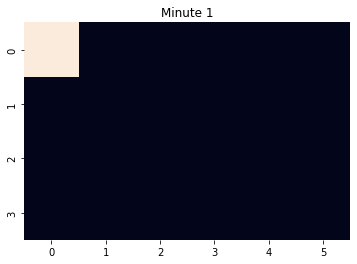

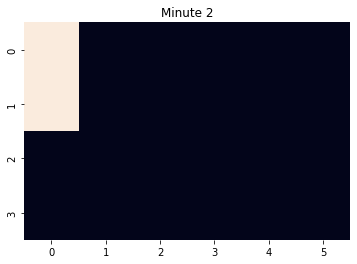

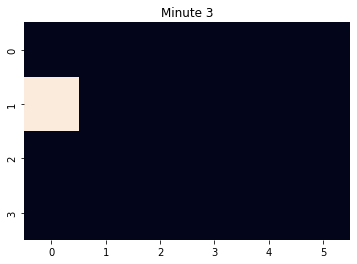

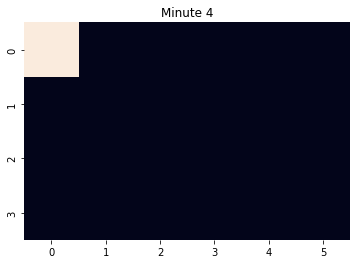

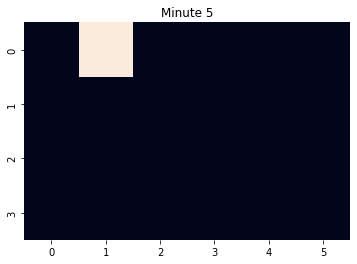

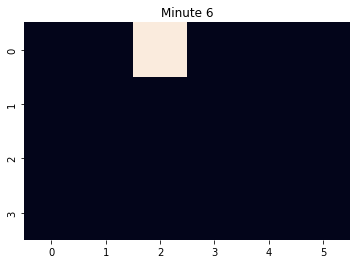

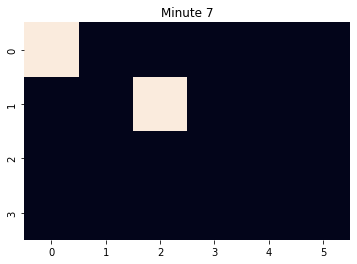

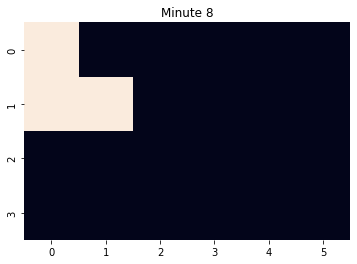

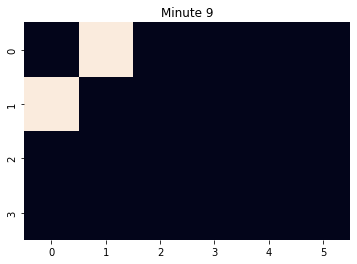

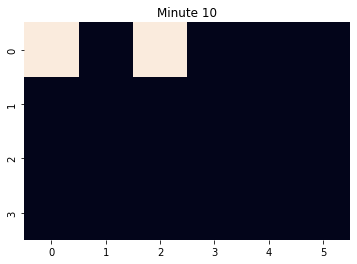

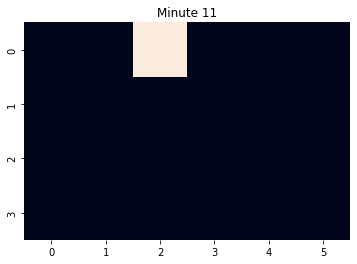

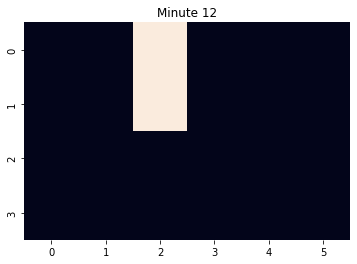

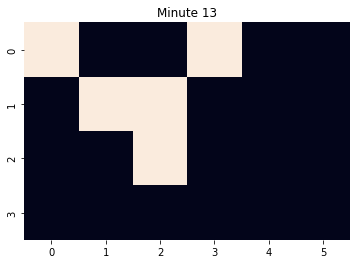

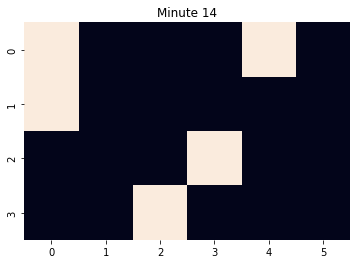

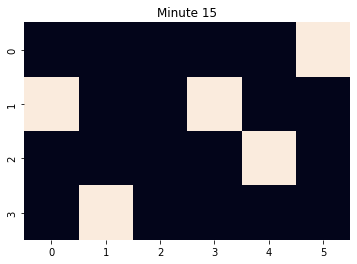

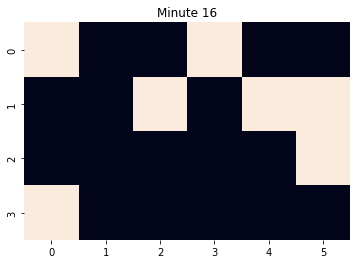

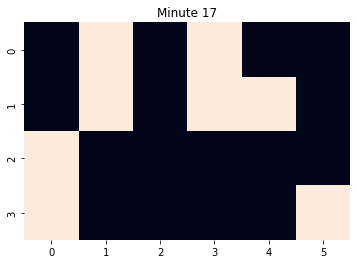

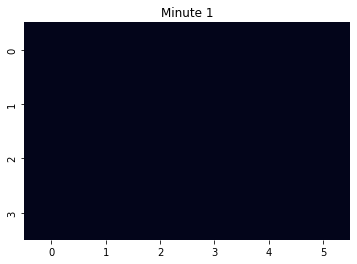

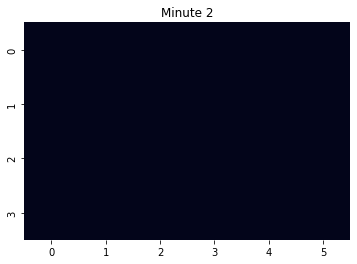

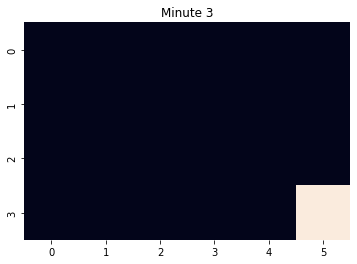

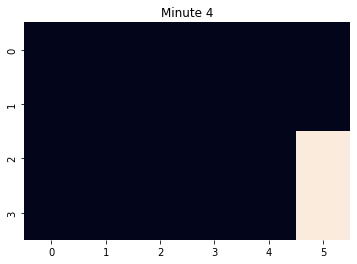

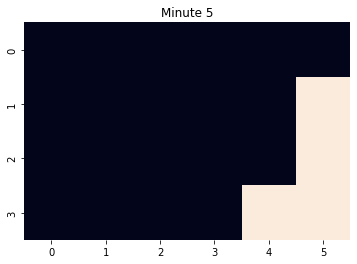

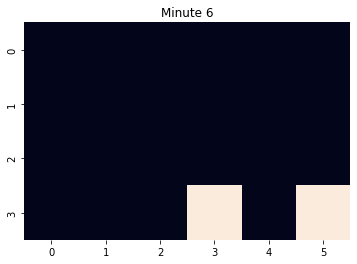

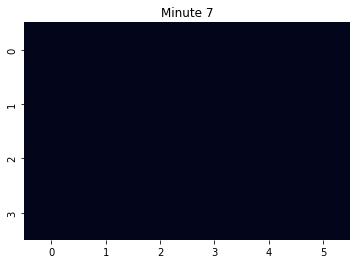

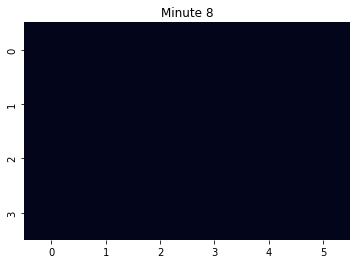

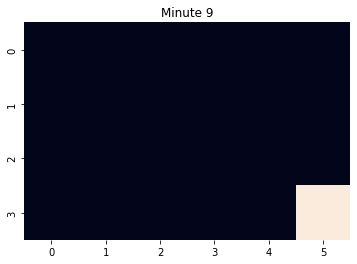

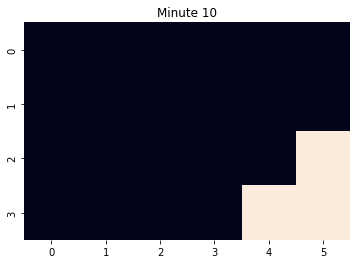

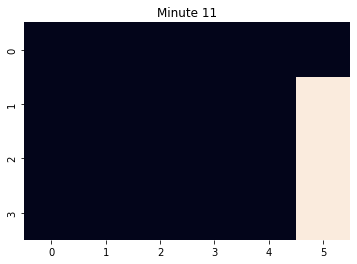

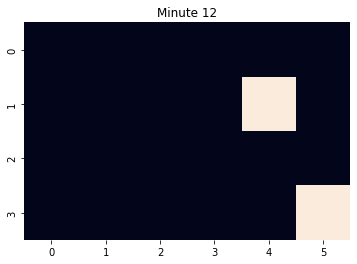

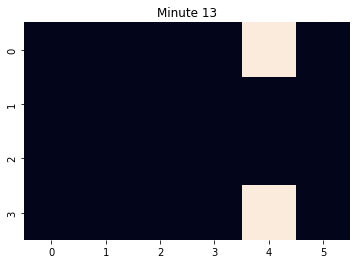

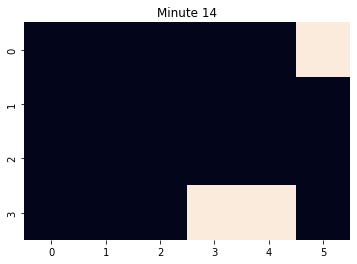

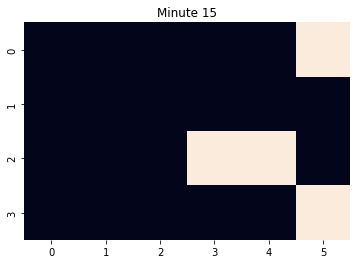

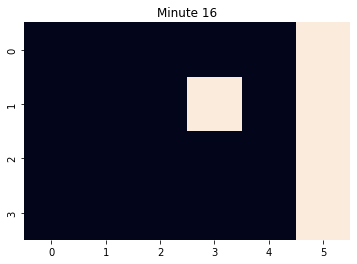

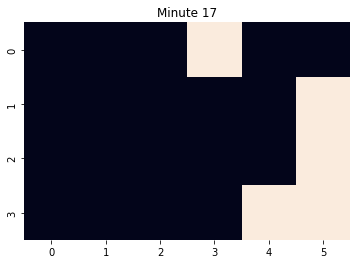

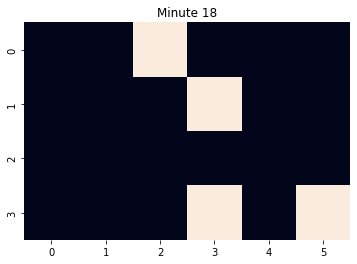

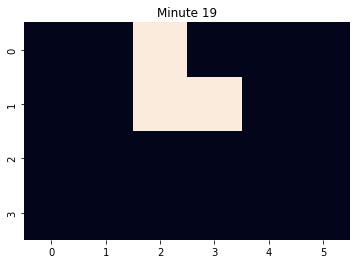

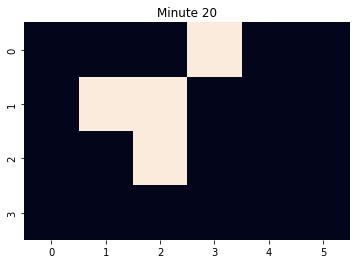

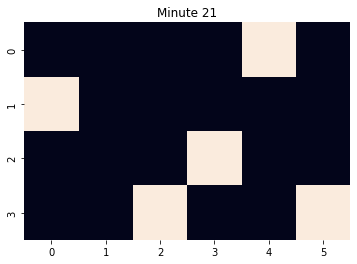

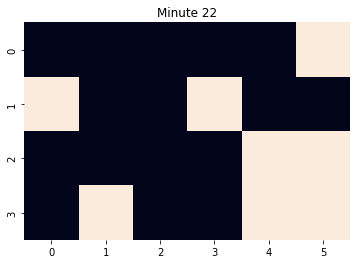

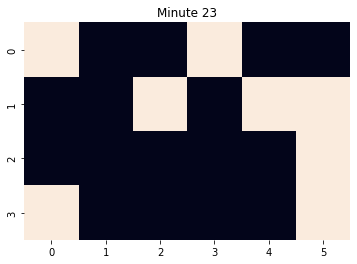

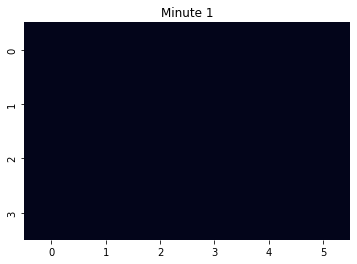

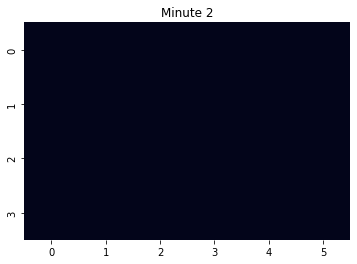

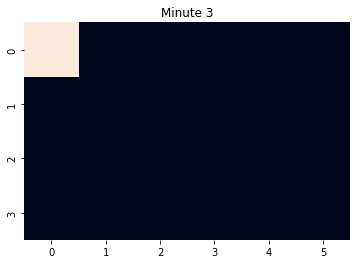

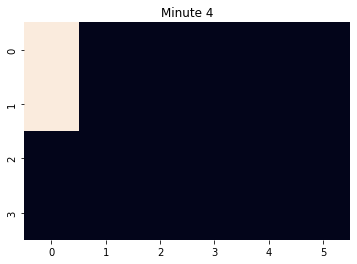

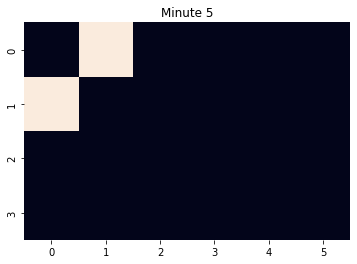

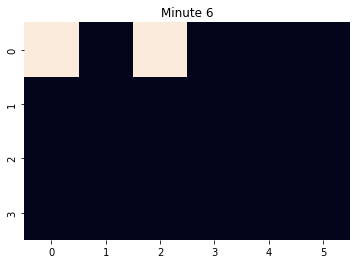

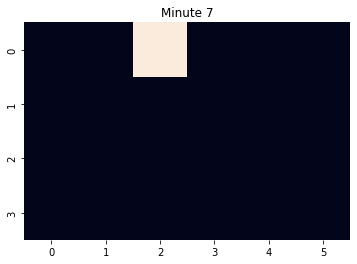

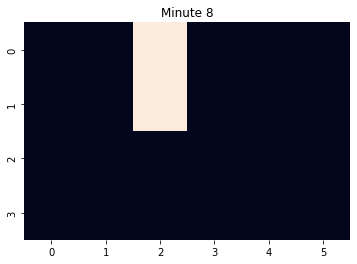

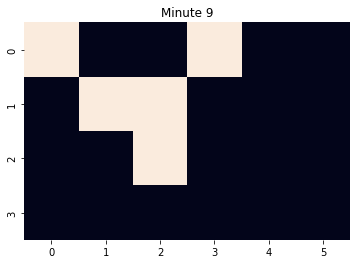

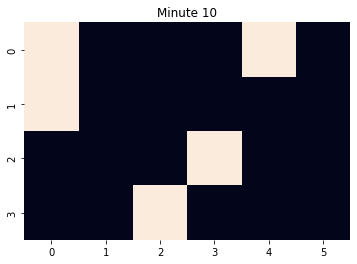

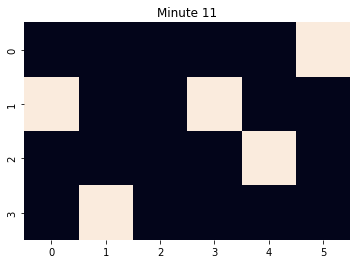

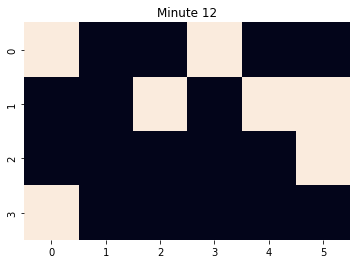

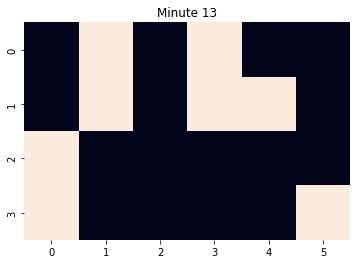

18 24 14 56


In [10]:
g = Storms(gtest,verbose = True)
a = g.time_through_storm(plots=True)
b = g.backwards_time_through_storm(plots = True)
c = g.time_through_storm(plots = True)
print(a,b,c,a+b+c)

[['<' '<' '<' ... '<' '^' '>']
 ['>' '^' '^' ... '>' '>' '>']
 ['<' '<' '.' ... 'v' 'v' '>']
 ...
 ['<' '^' '<' ... '^' 'v' '>']
 ['<' '>' '<' ... 'v' 'v' '<']
 ['<' '<' 'v' ... '>' '>' '>']]


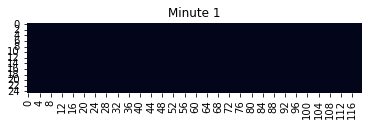

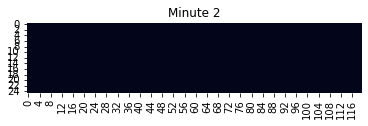

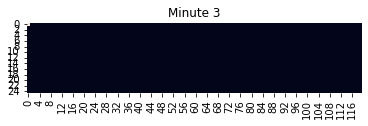

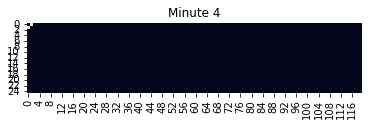

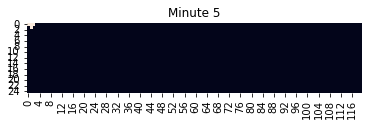

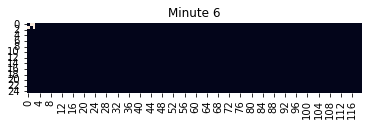

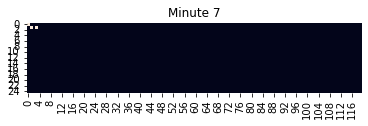

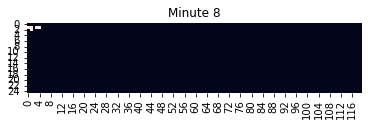

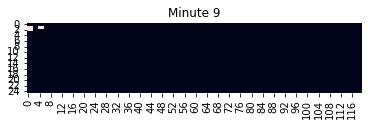

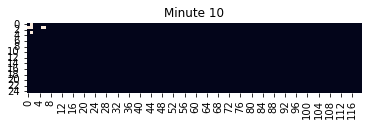

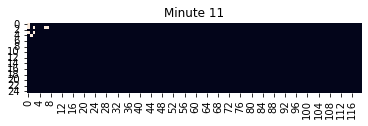

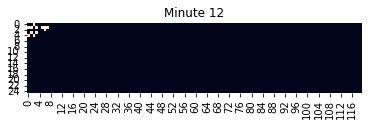

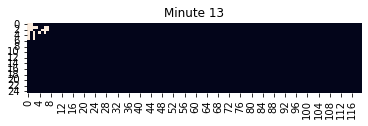

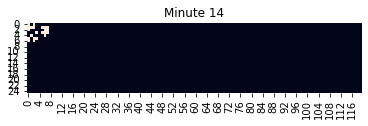

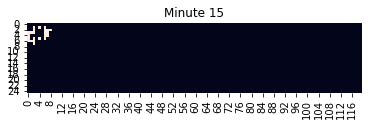

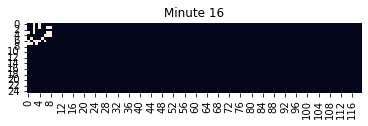

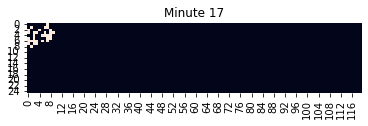

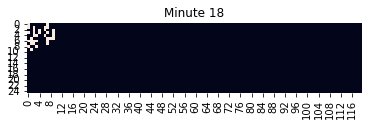

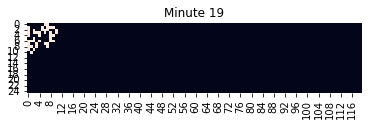

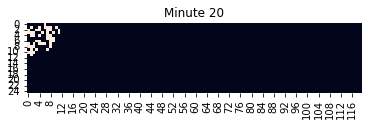

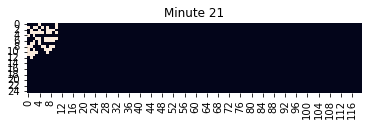

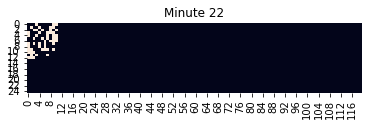

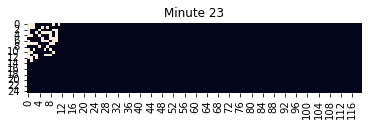

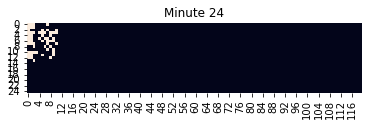

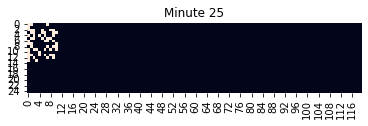

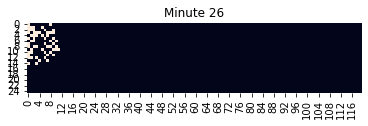

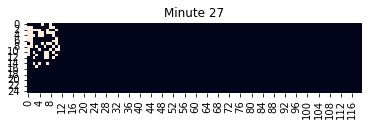

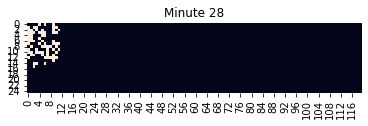

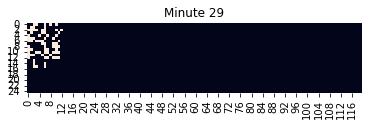

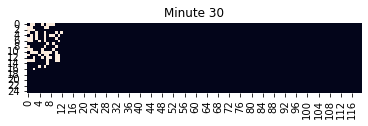

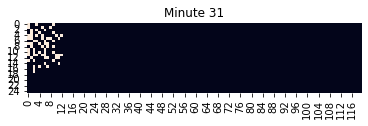

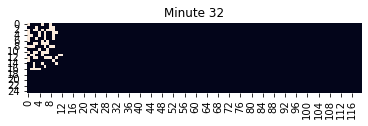

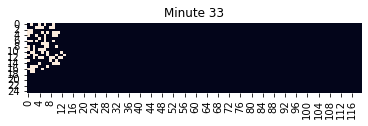

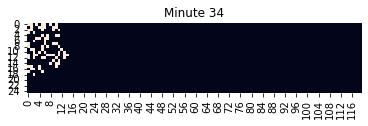

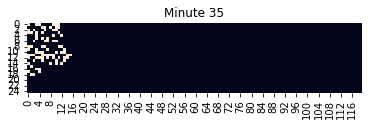

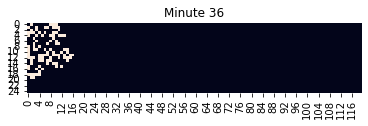

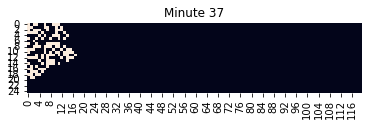

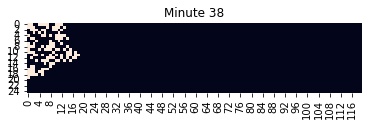

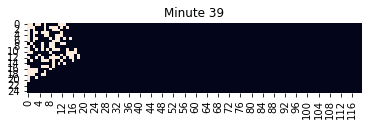

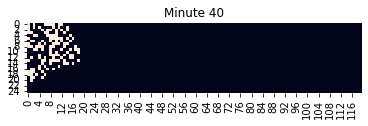

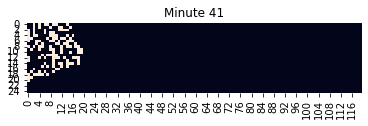

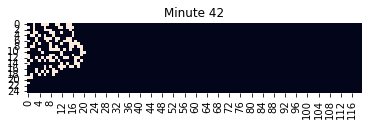

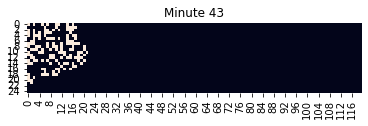

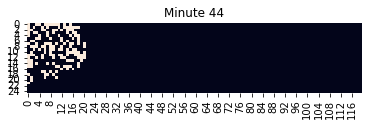

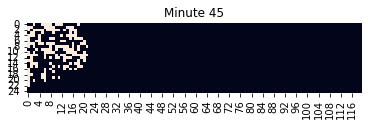

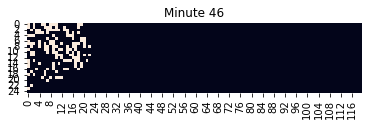

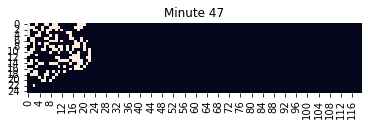

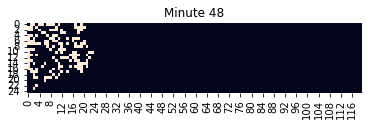

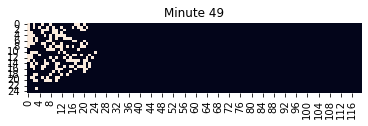

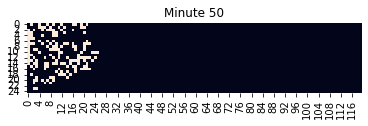

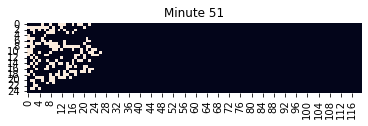

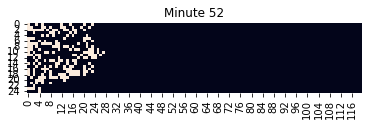

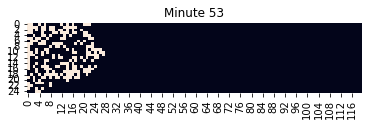

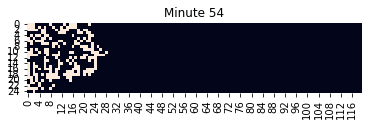

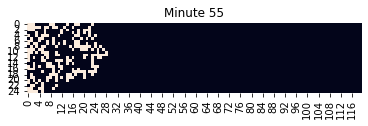

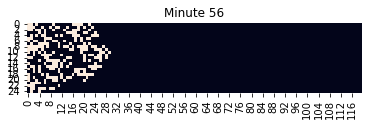

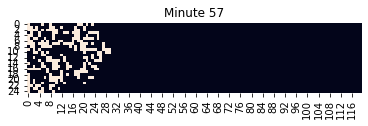

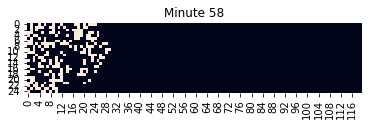

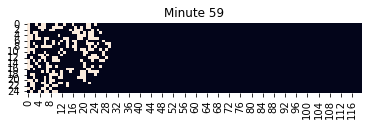

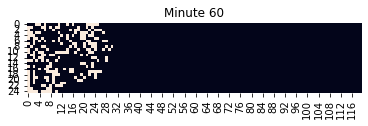

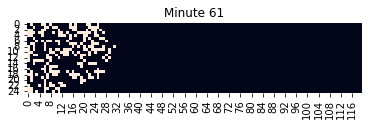

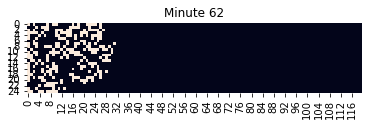

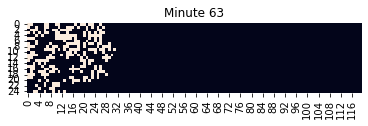

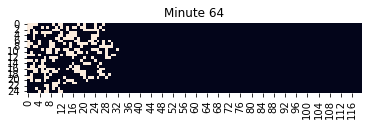

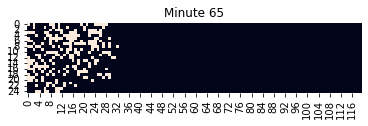

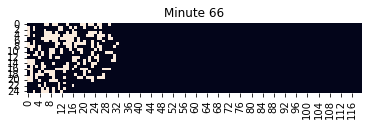

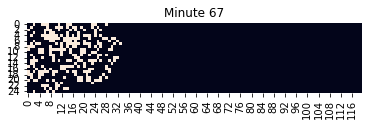

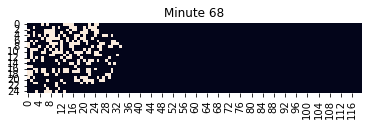

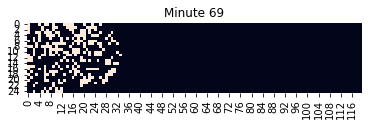

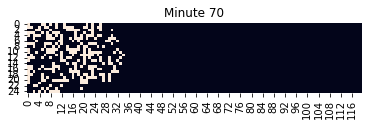

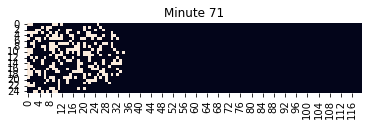

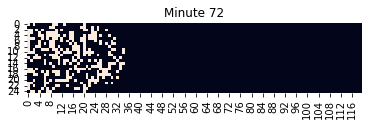

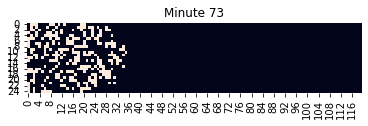

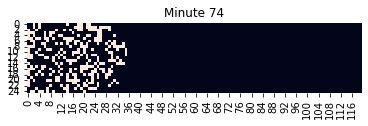

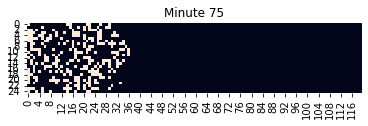

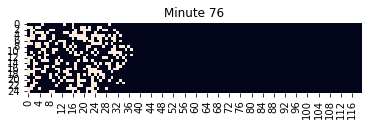

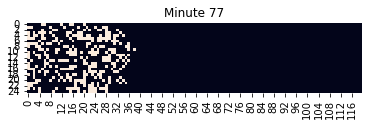

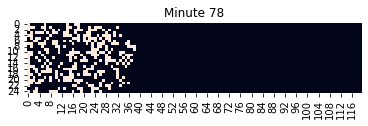

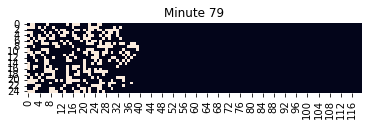

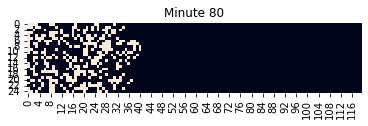

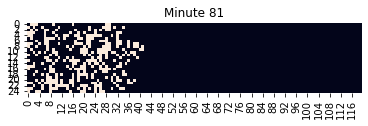

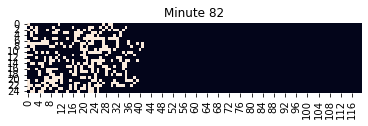

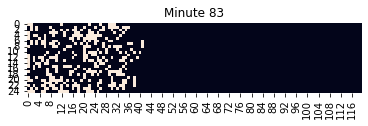

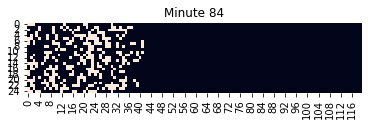

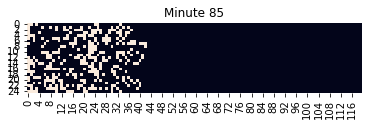

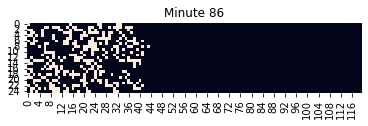

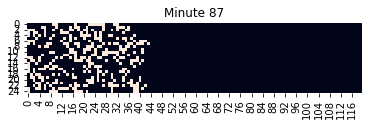

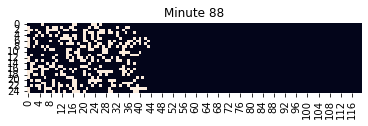

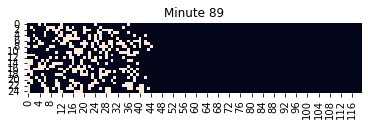

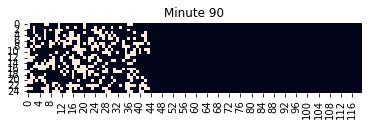

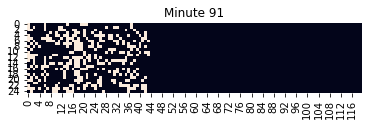

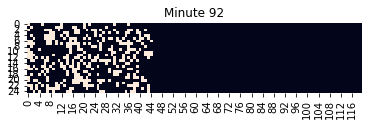

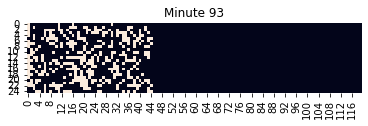

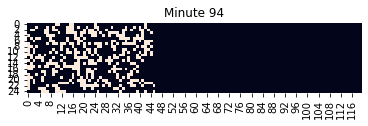

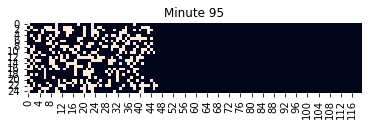

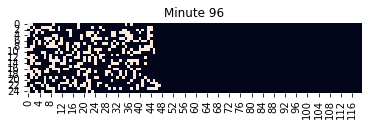

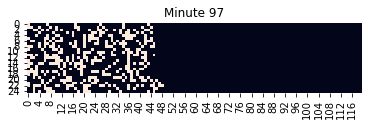

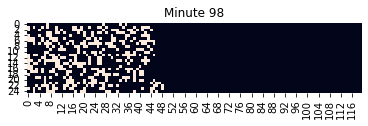

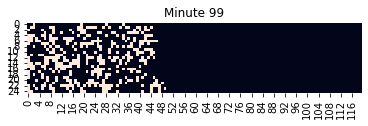

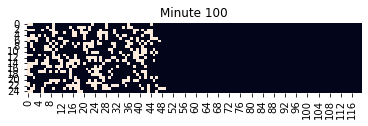

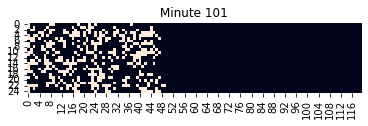

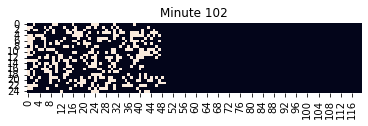

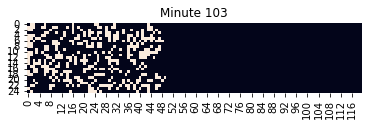

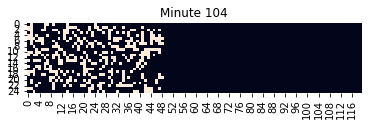

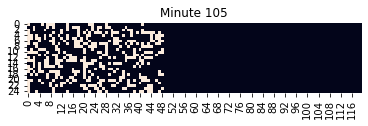

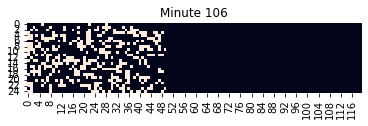

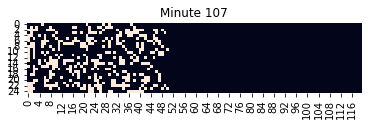

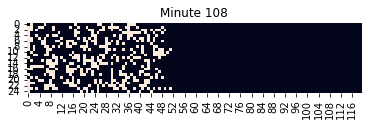

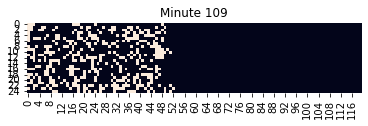

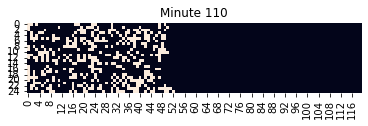

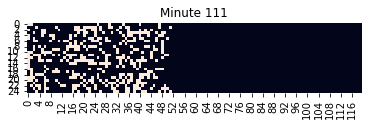

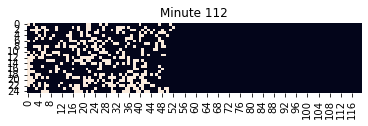

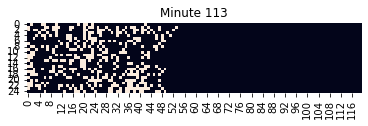

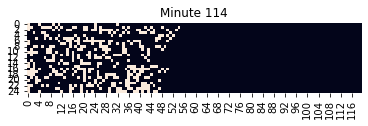

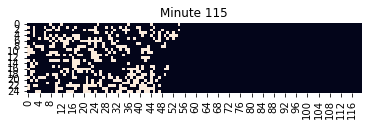

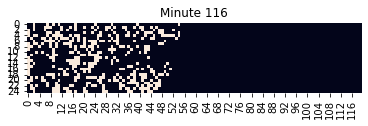

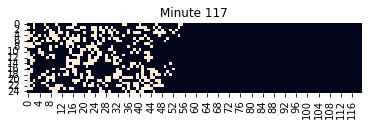

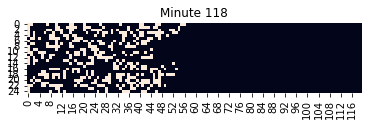

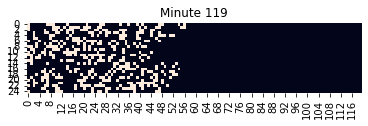

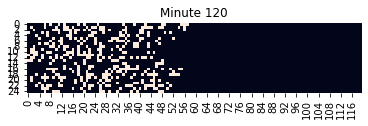

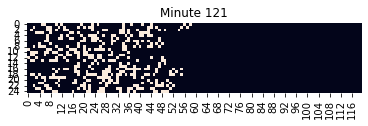

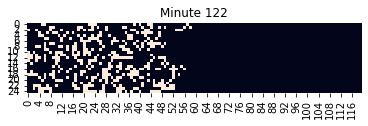

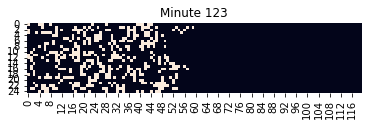

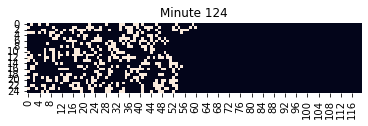

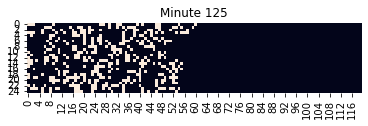

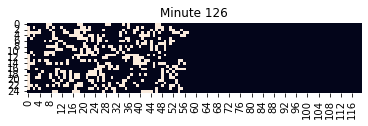

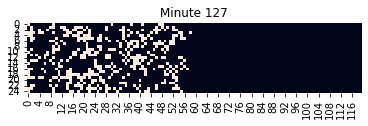

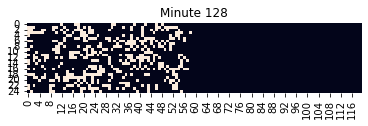

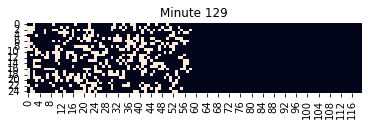

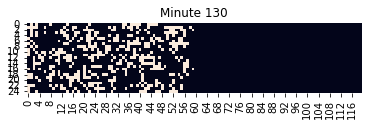

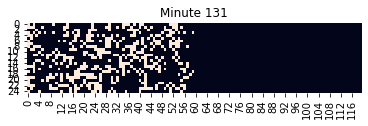

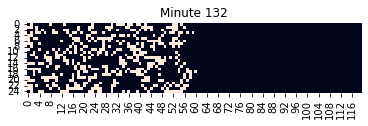

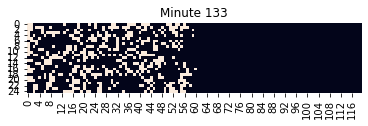

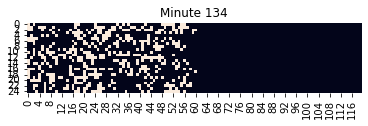

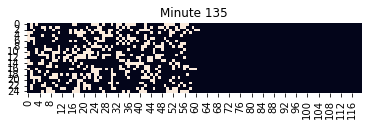

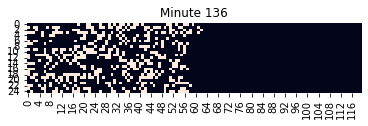

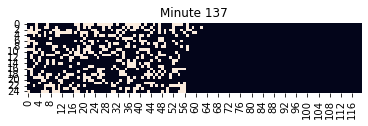

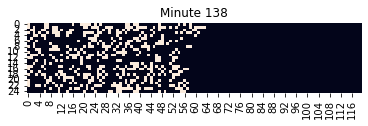

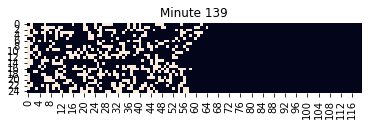

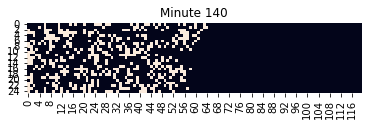

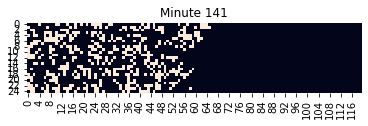

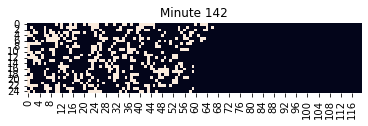

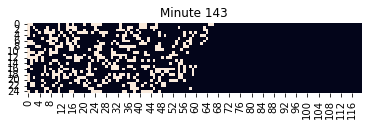

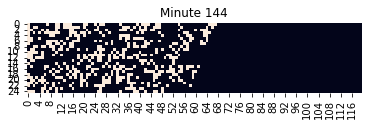

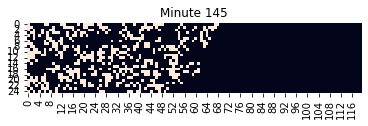

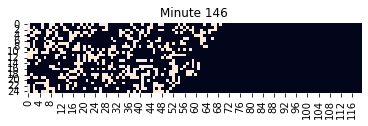

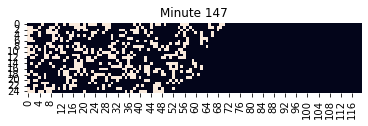

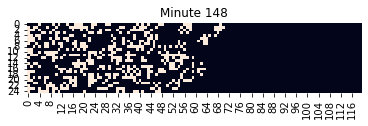

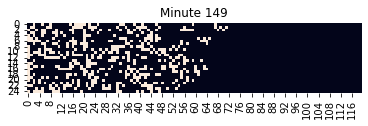

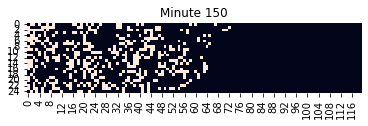

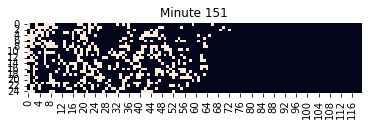

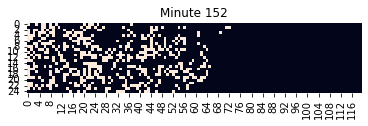

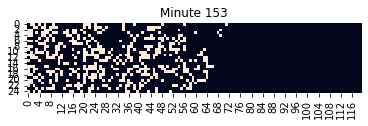

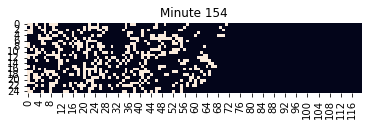

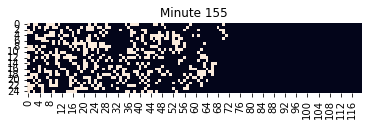

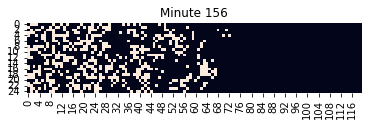

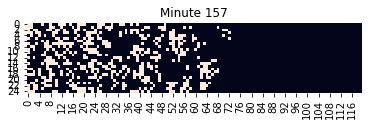

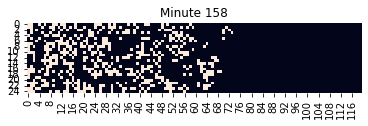

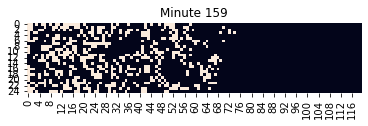

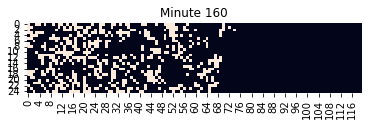

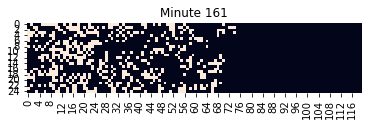

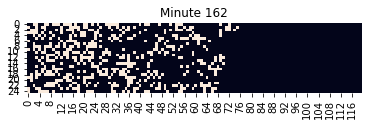

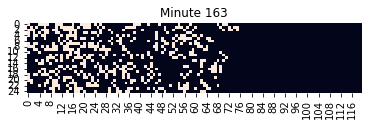

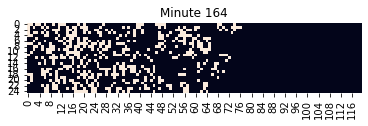

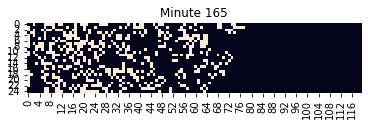

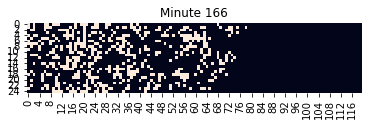

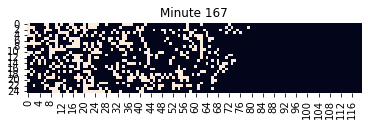

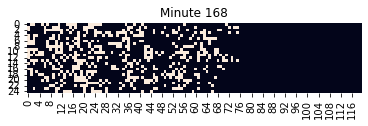

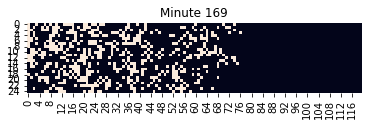

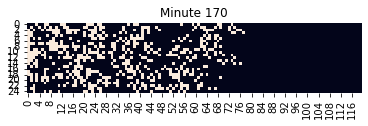

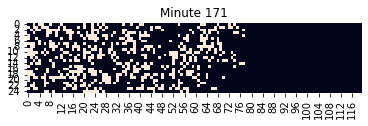

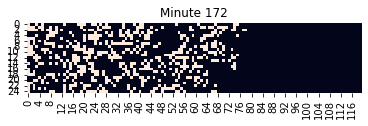

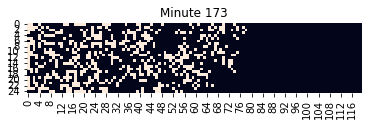

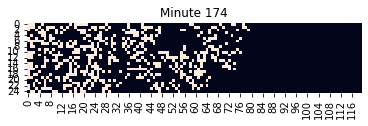

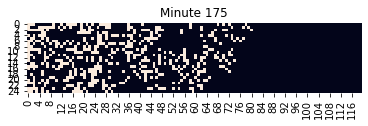

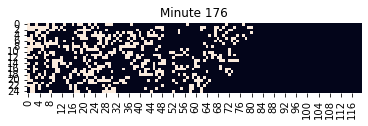

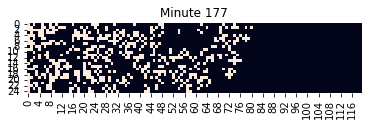

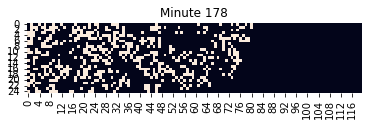

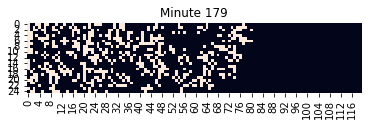

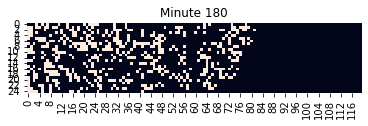

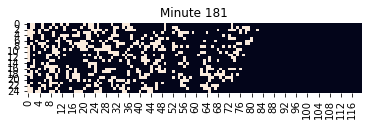

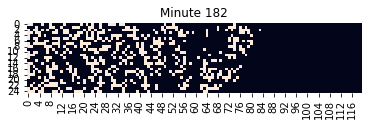

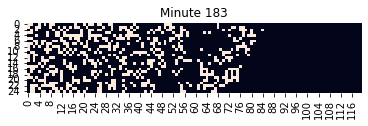

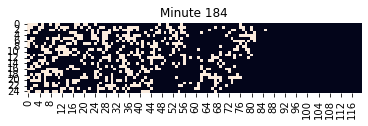

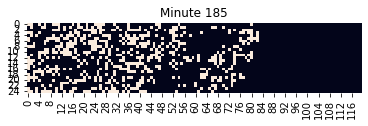

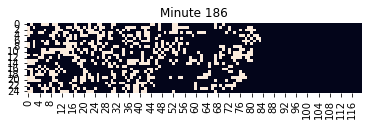

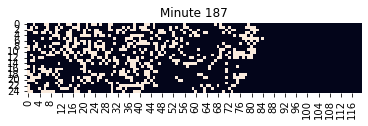

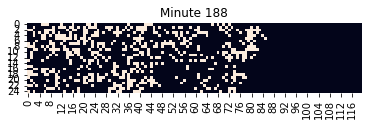

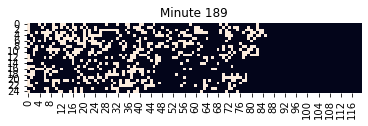

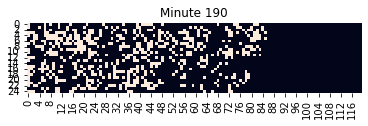

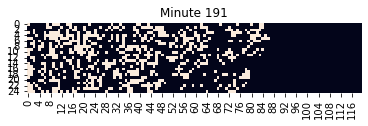

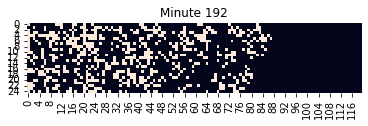

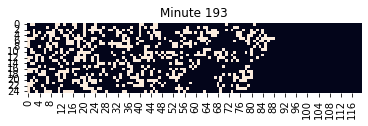

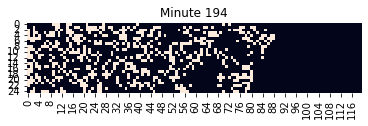

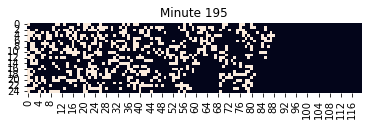

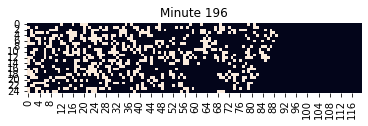

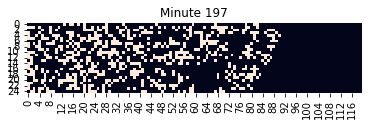

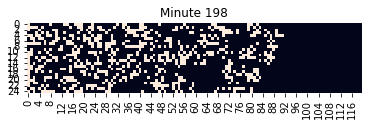

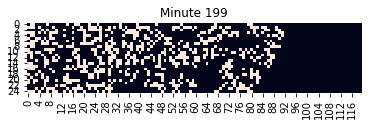

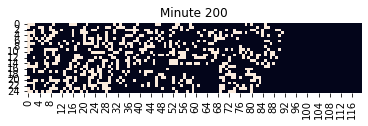

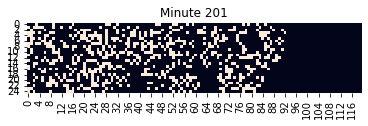

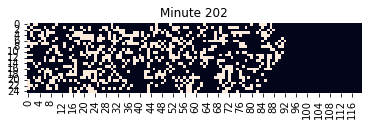

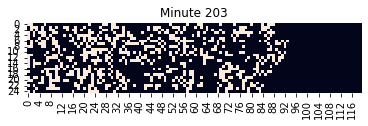

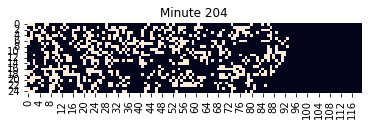

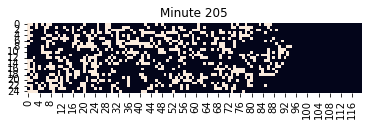

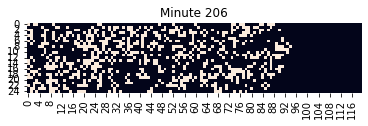

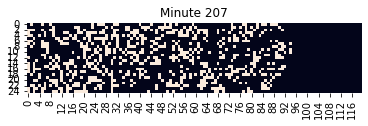

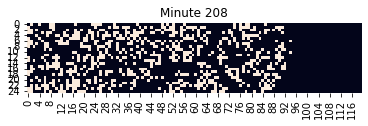

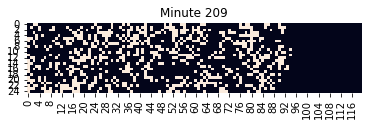

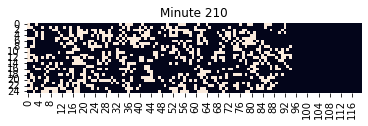

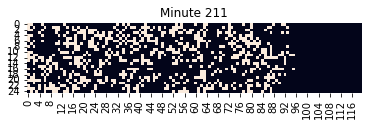

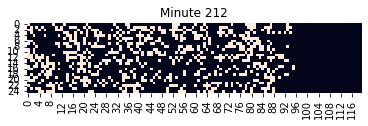

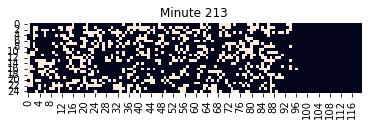

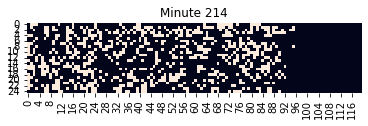

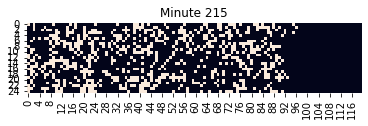

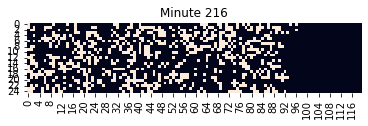

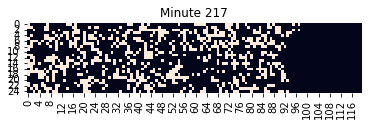

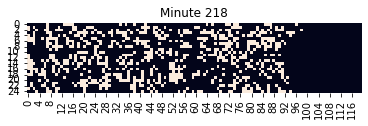

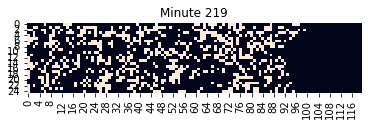

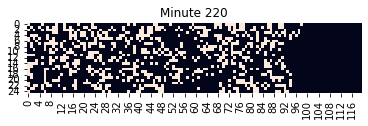

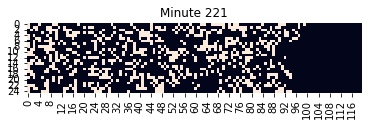

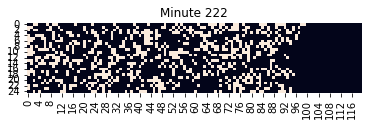

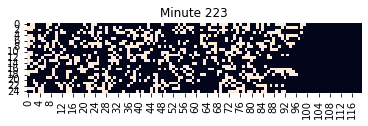

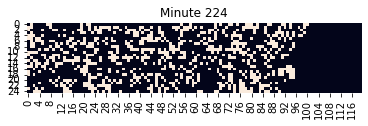

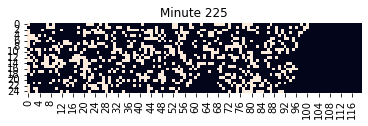

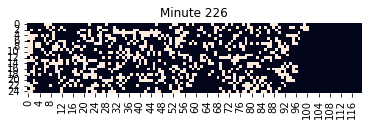

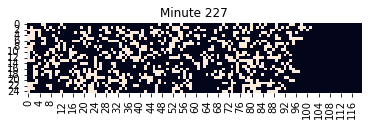

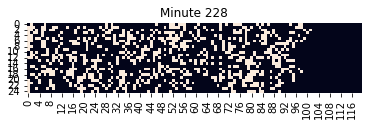

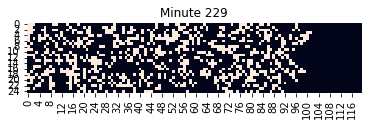

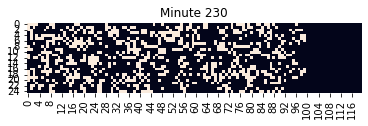

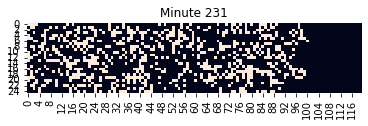

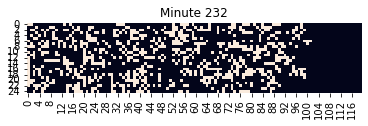

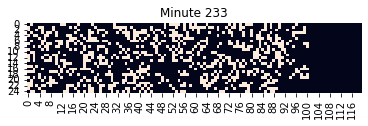

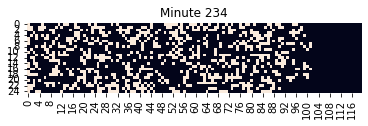

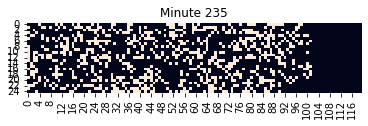

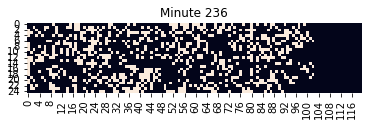

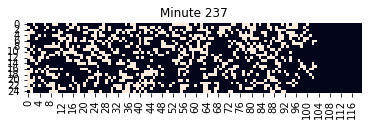

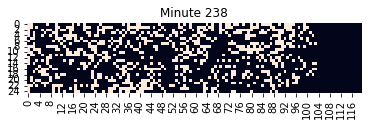

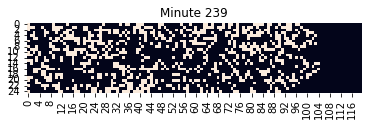

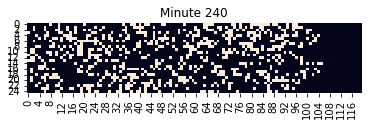

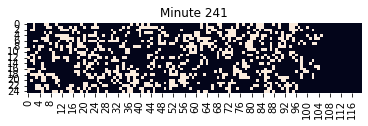

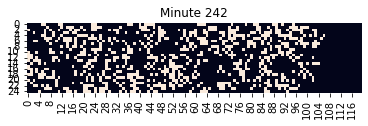

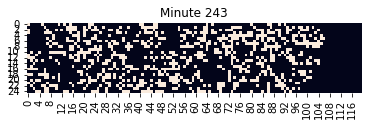

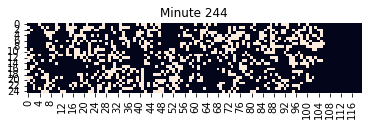

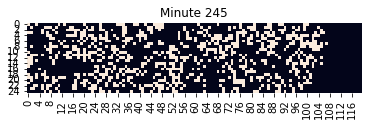

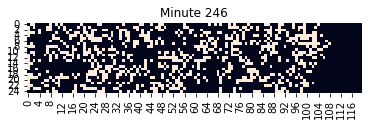

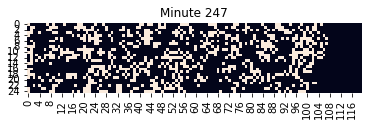

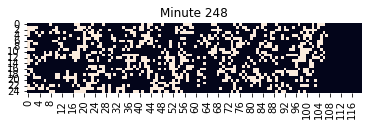

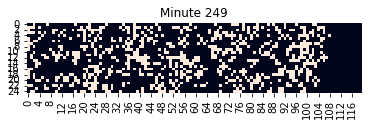

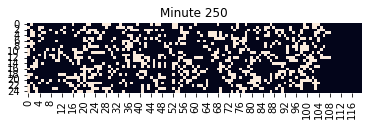

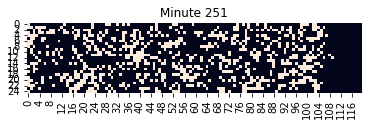

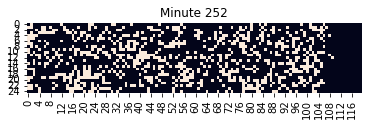

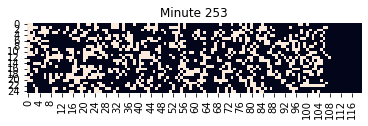

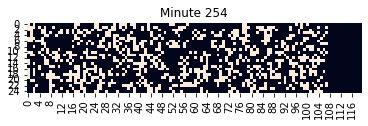

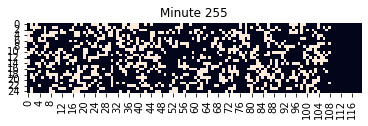

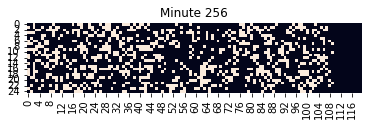

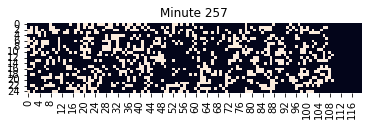

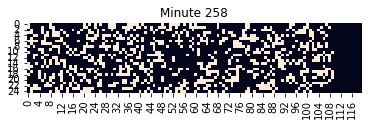

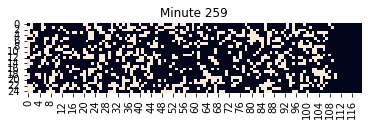

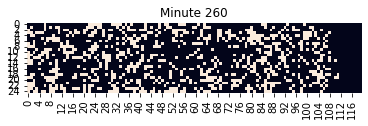

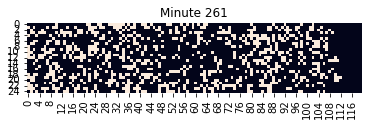

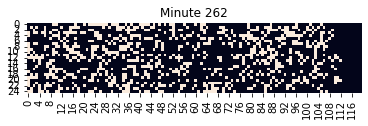

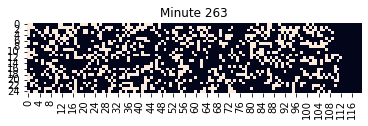

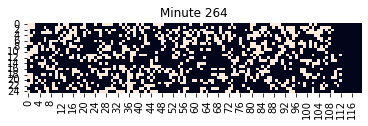

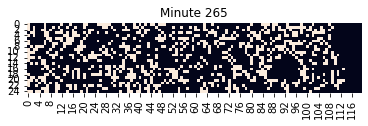

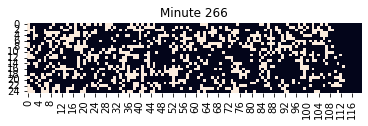

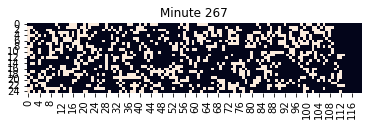

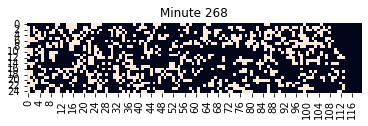

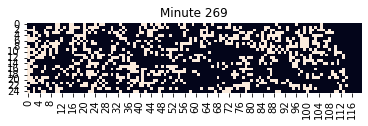

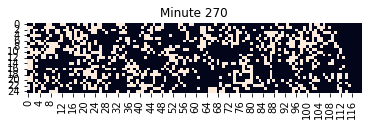

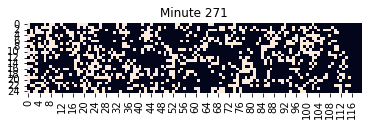

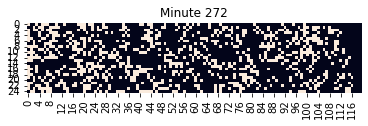

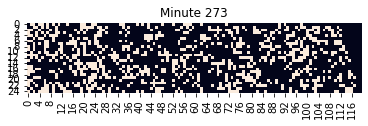

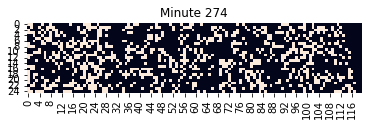

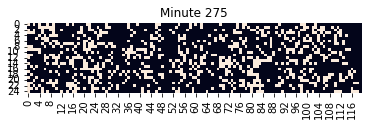

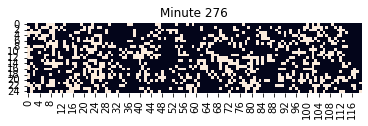

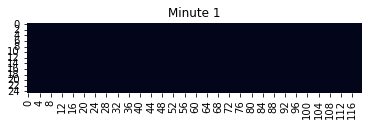

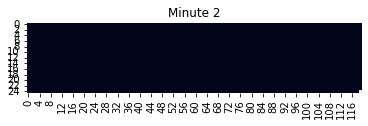

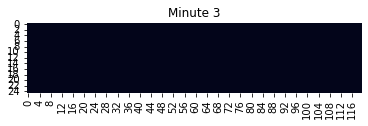

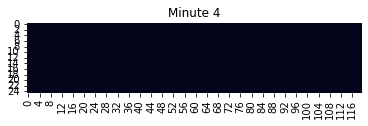

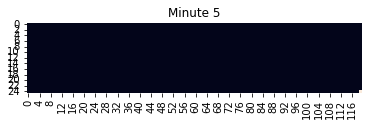

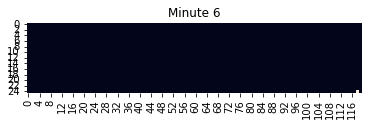

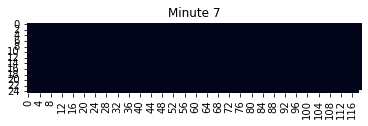

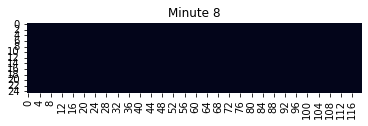

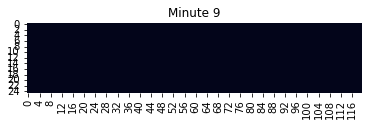

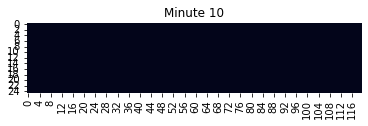

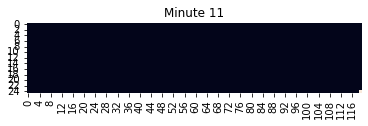

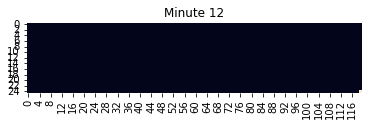

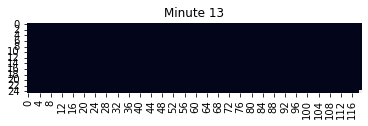

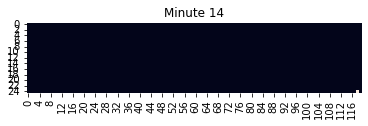

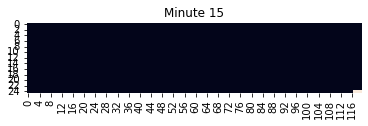

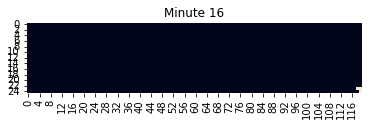

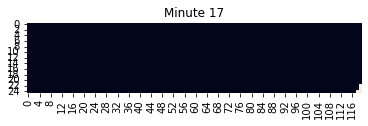

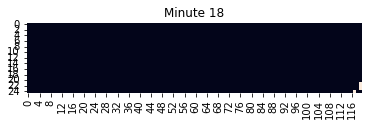

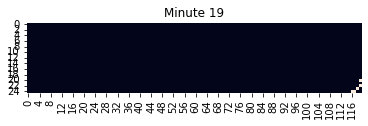

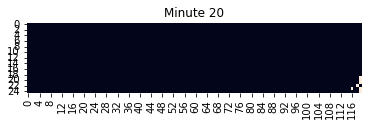

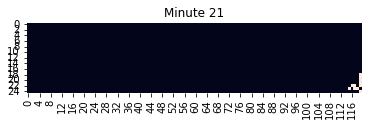

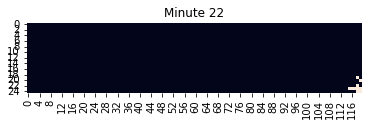

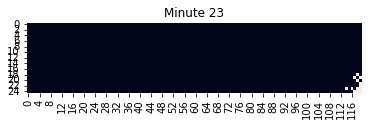

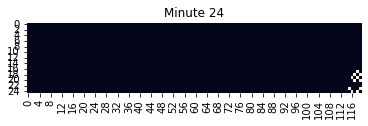

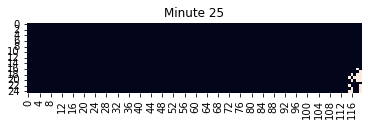

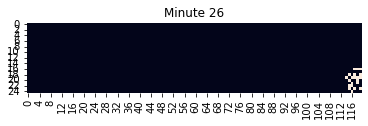

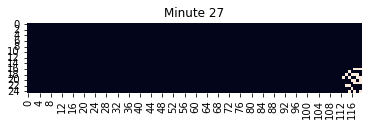

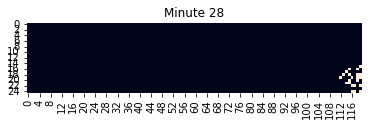

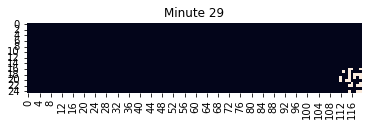

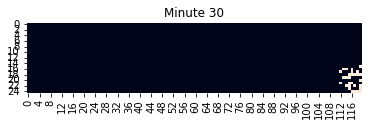

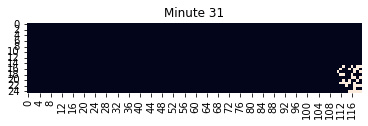

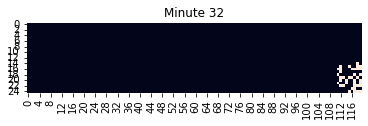

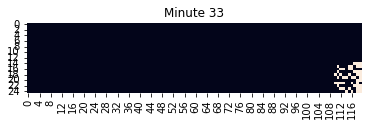

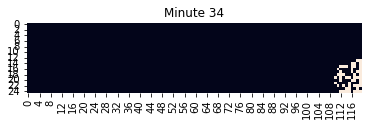

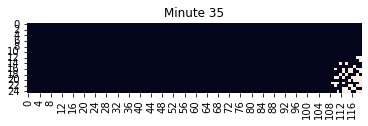

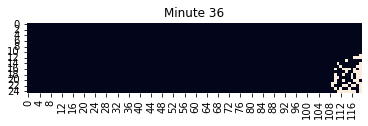

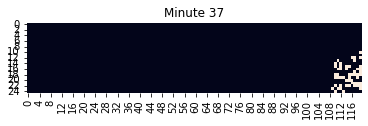

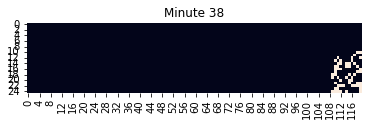

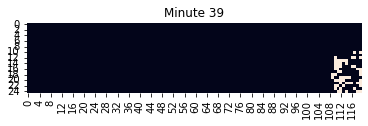

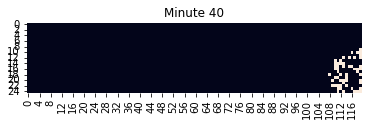

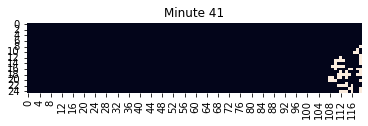

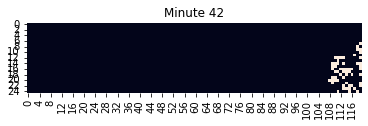

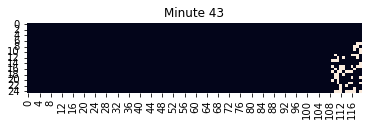

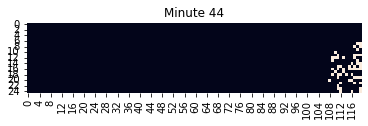

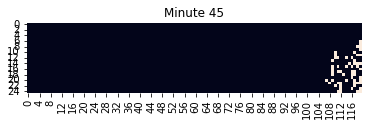

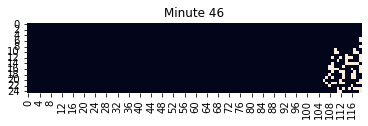

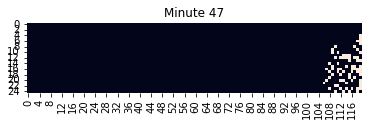

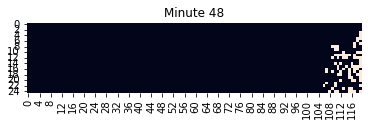

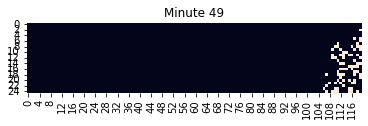

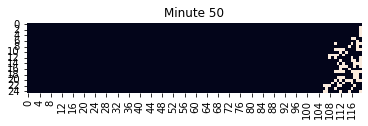

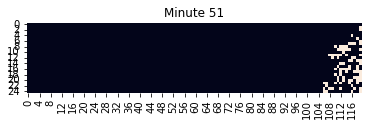

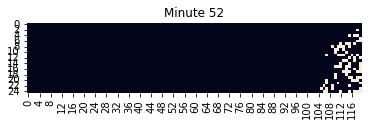

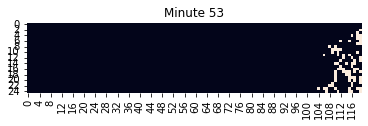

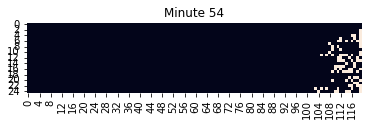

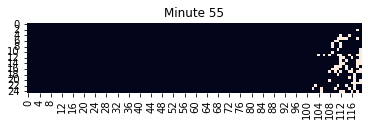

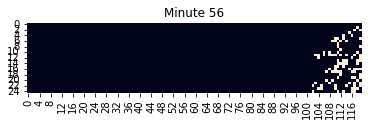

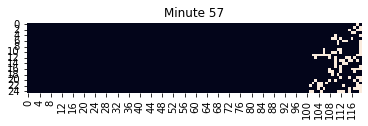

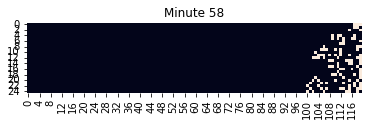

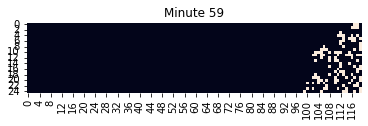

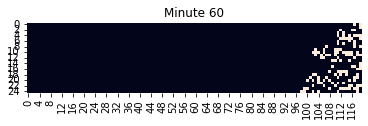

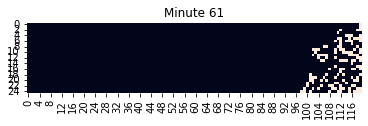

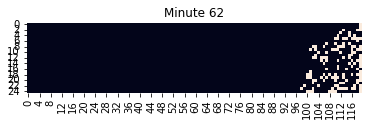

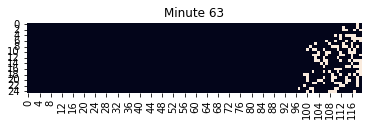

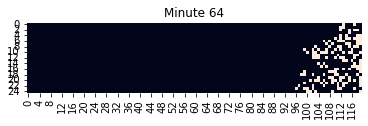

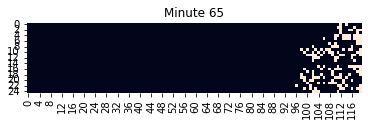

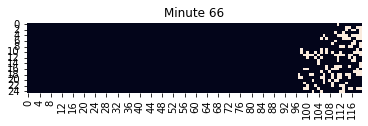

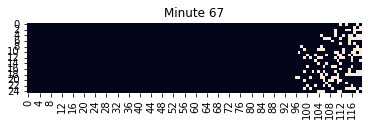

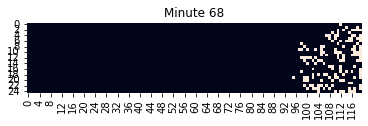

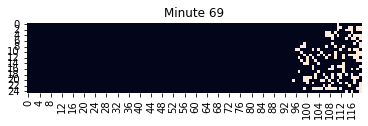

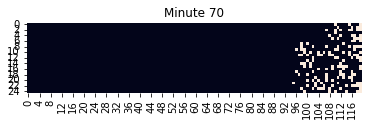

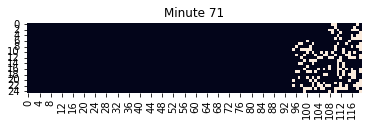

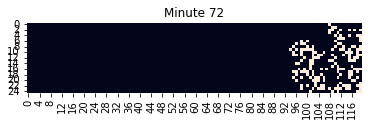

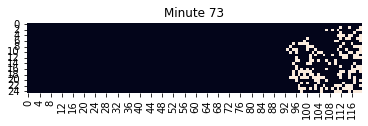

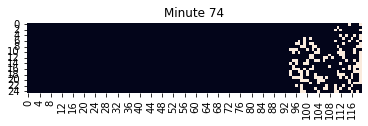

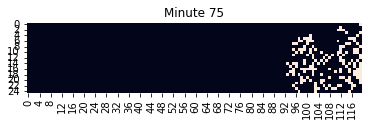

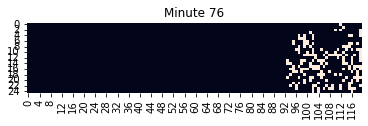

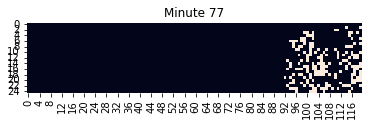

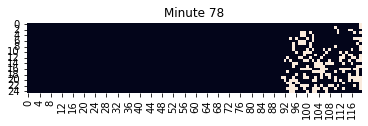

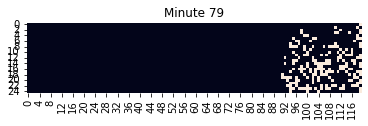

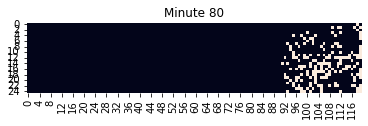

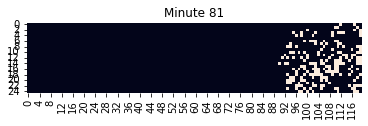

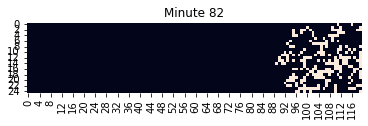

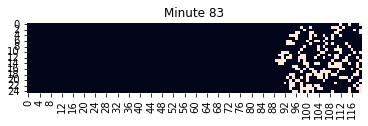

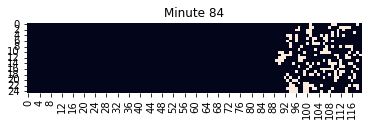

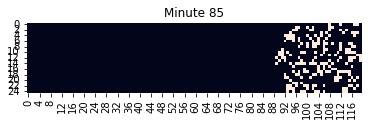

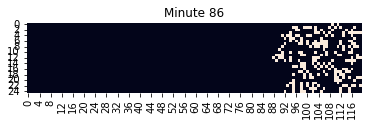

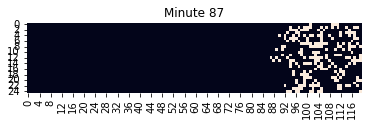

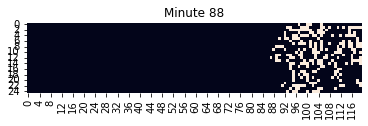

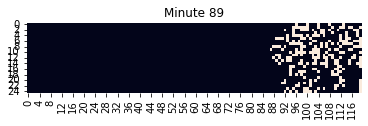

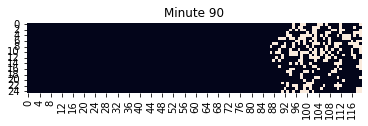

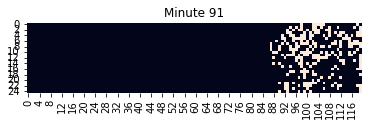

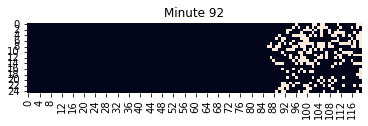

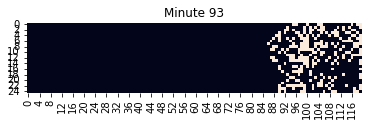

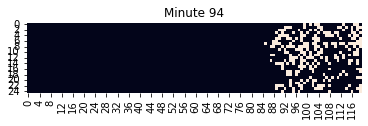

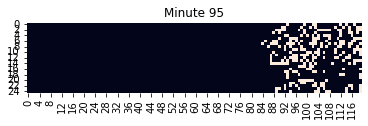

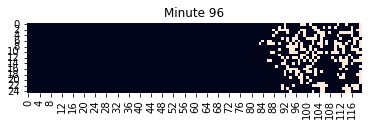

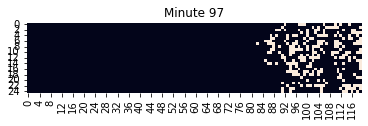

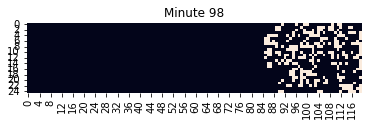

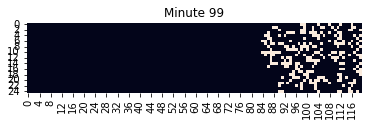

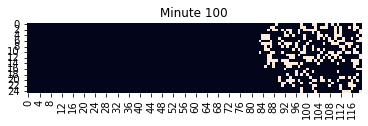

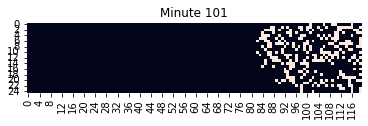

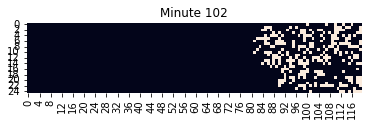

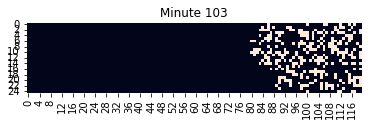

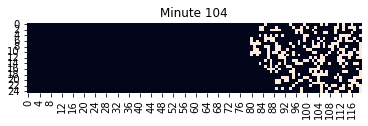

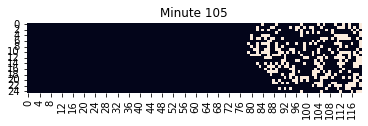

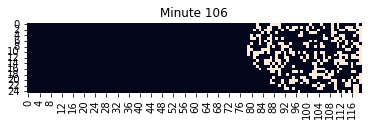

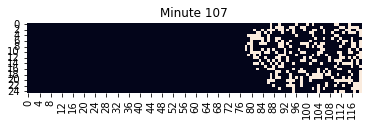

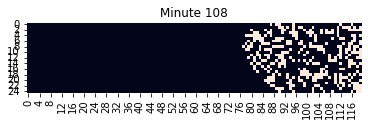

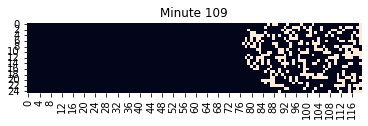

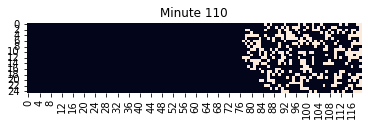

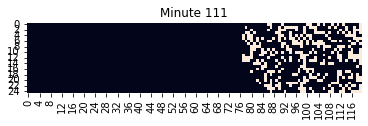

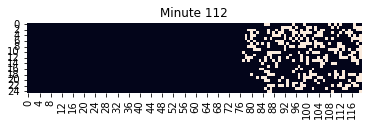

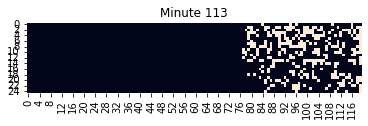

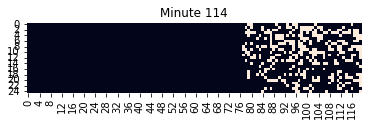

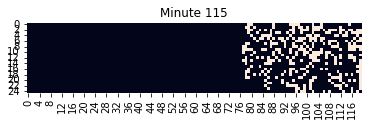

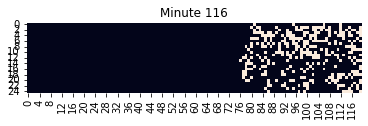

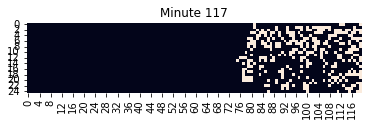

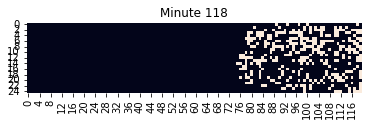

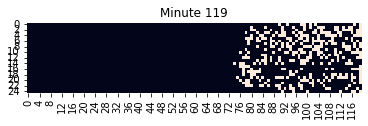

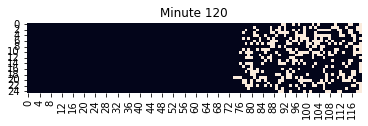

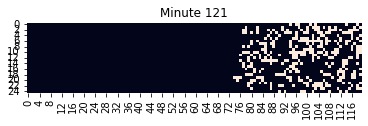

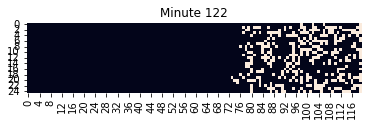

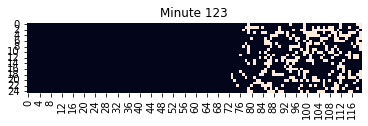

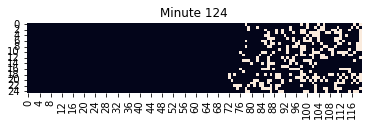

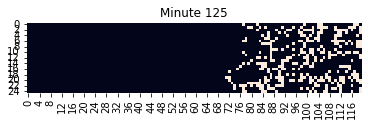

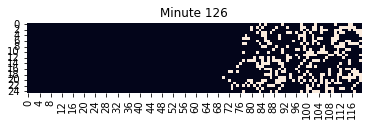

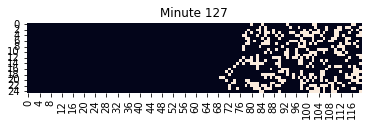

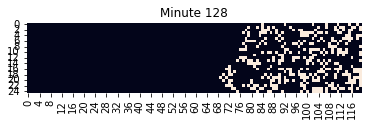

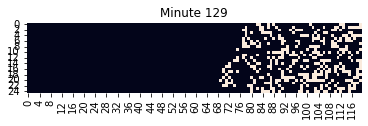

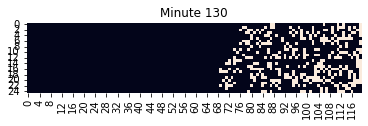

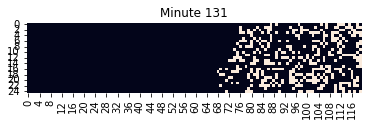

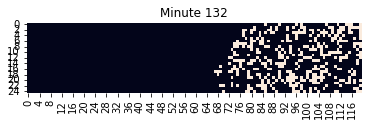

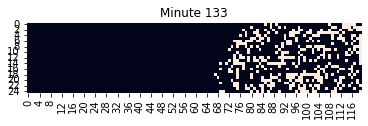

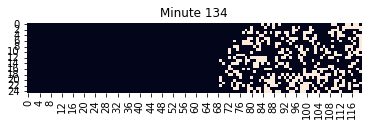

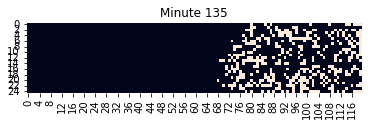

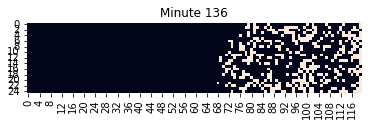

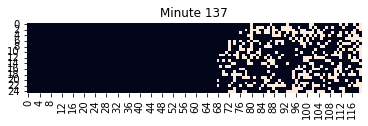

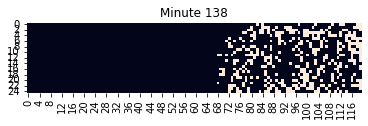

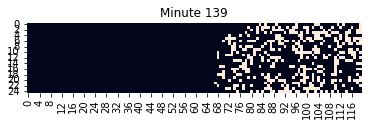

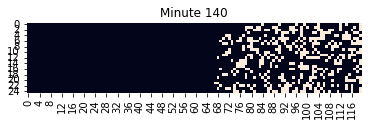

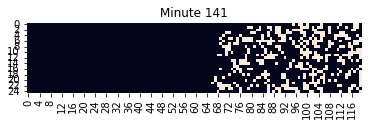

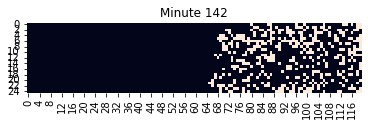

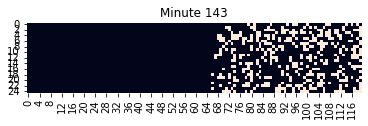

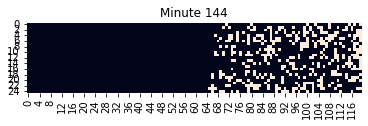

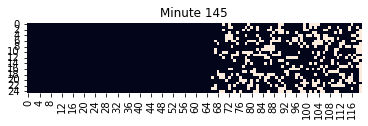

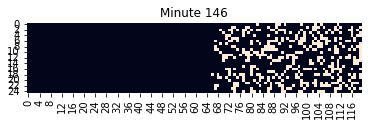

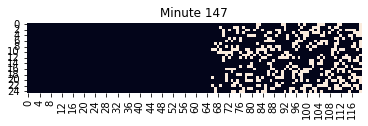

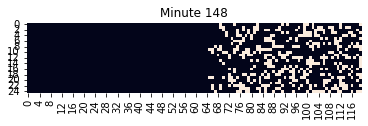

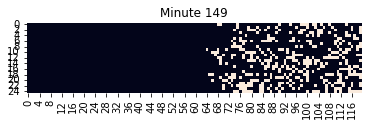

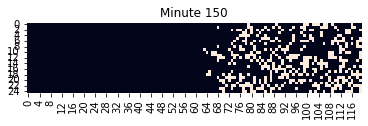

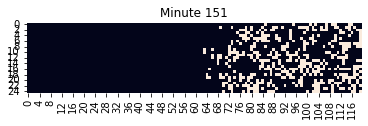

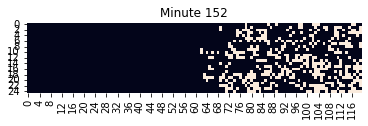

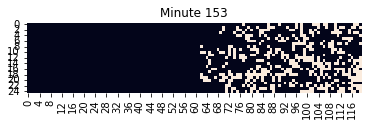

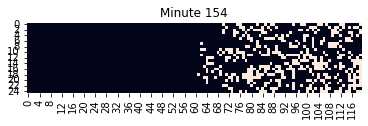

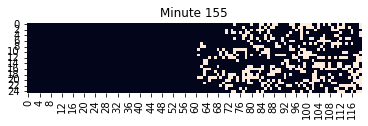

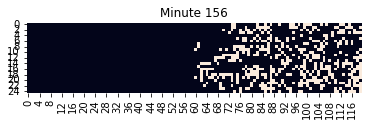

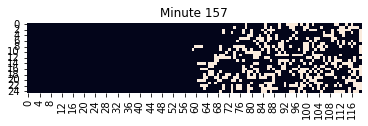

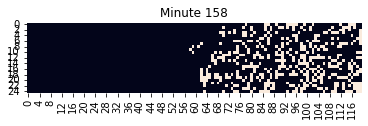

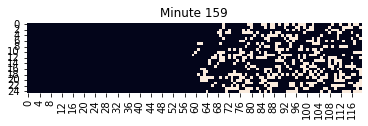

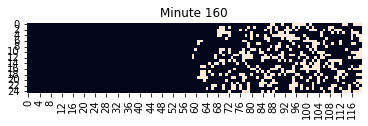

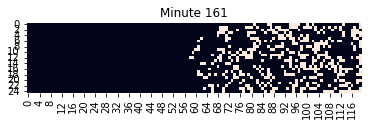

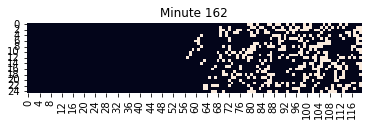

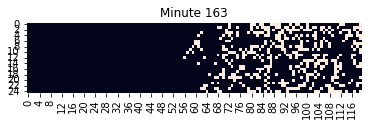

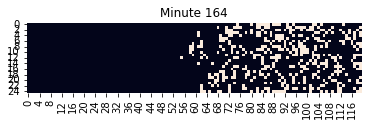

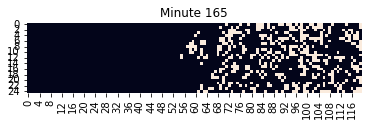

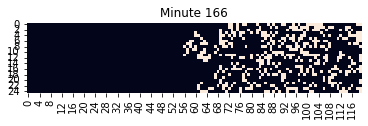

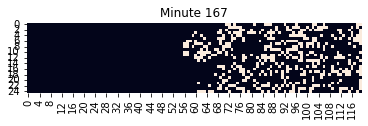

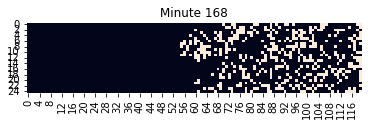

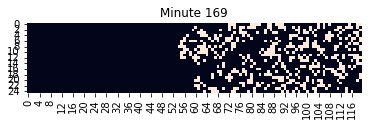

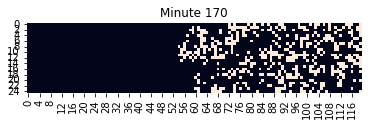

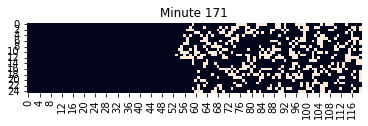

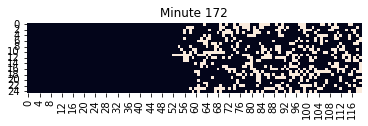

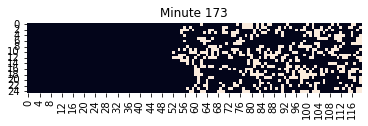

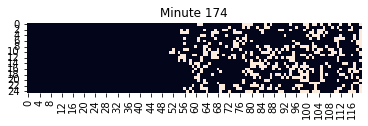

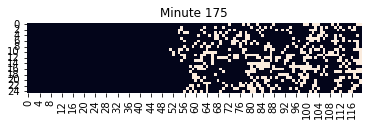

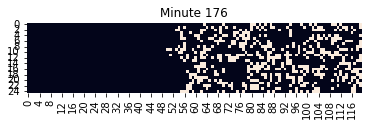

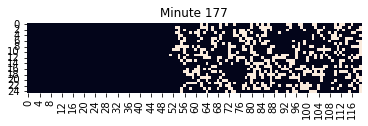

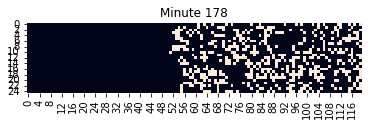

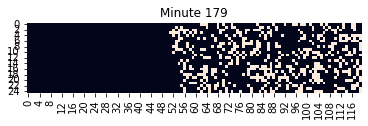

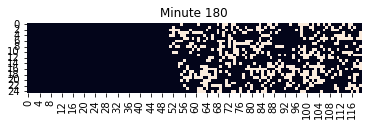

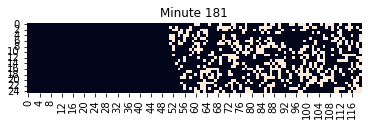

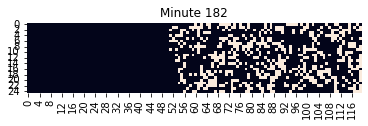

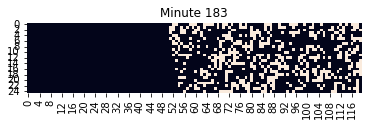

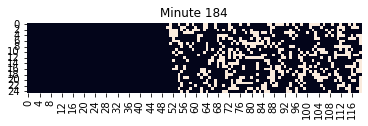

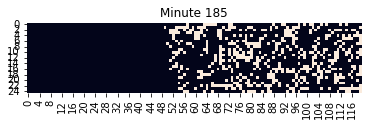

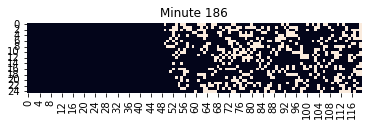

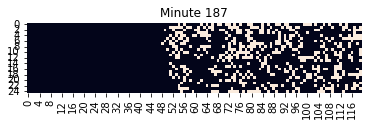

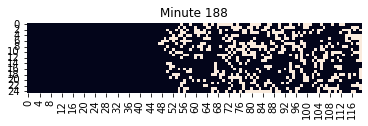

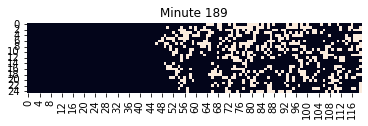

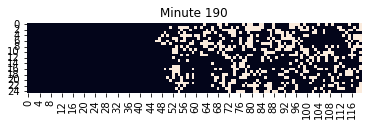

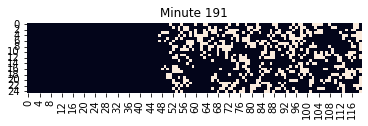

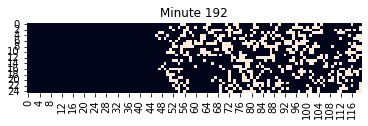

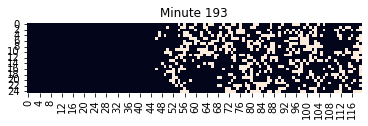

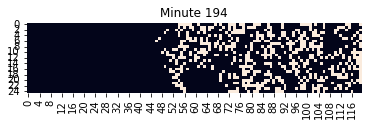

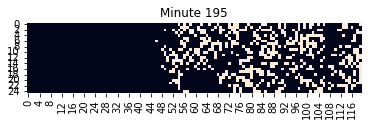

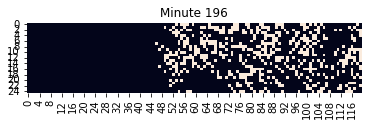

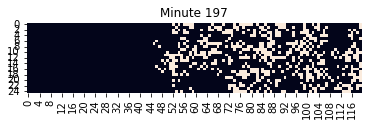

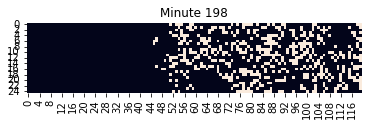

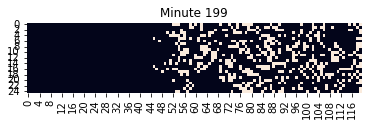

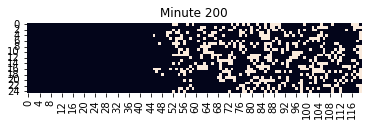

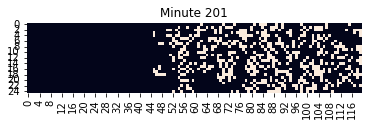

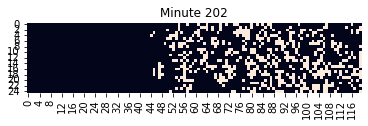

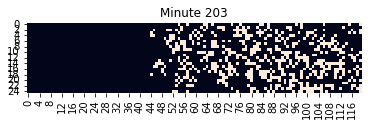

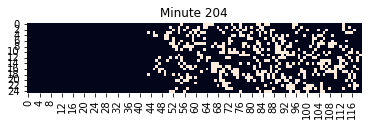

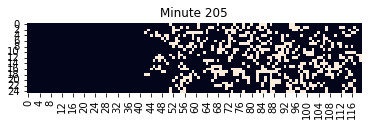

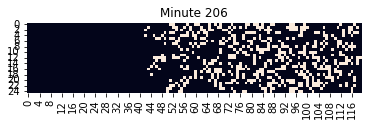

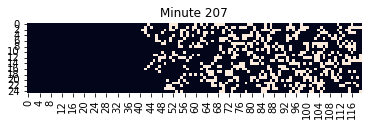

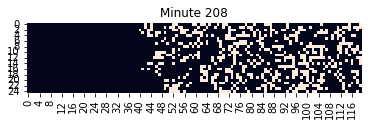

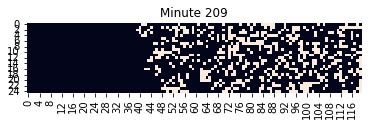

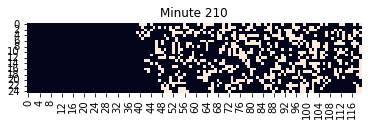

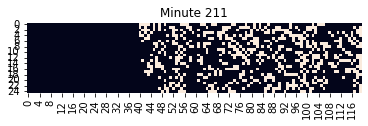

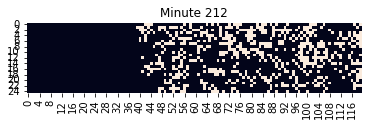

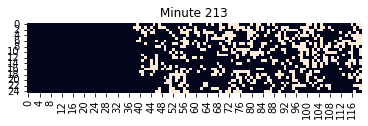

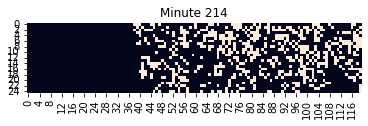

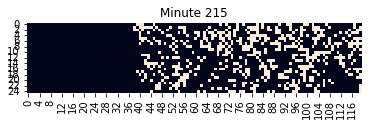

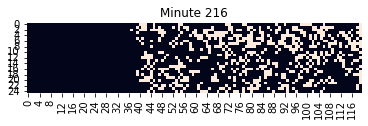

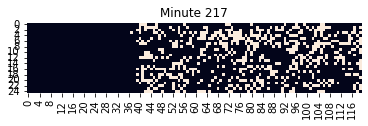

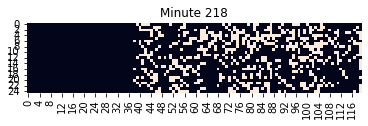

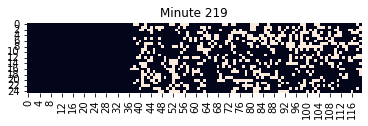

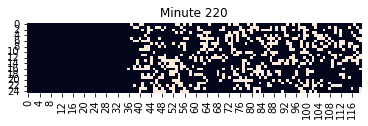

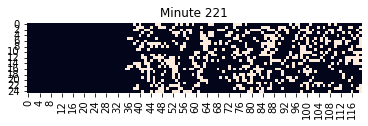

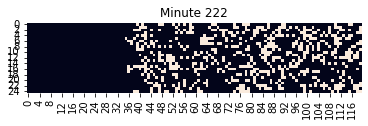

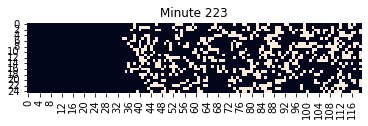

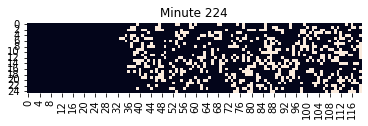

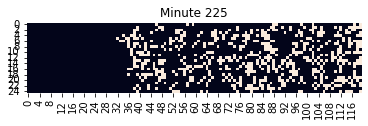

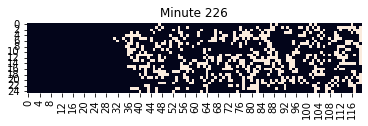

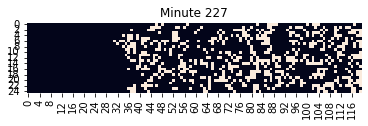

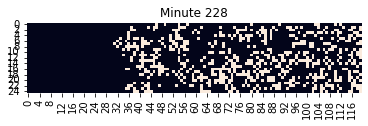

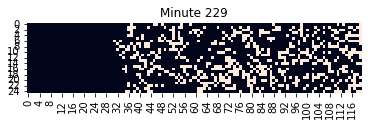

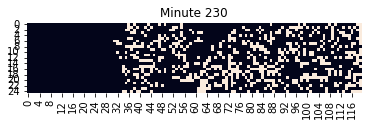

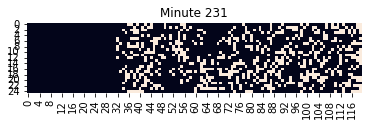

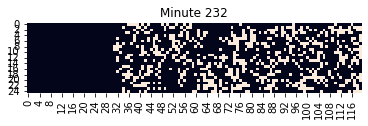

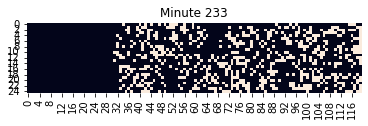

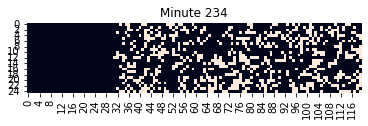

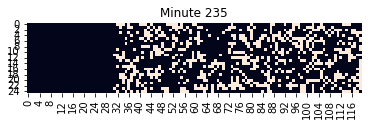

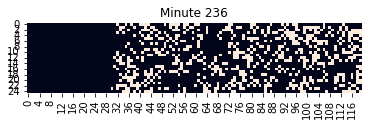

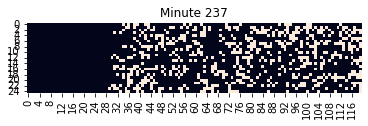

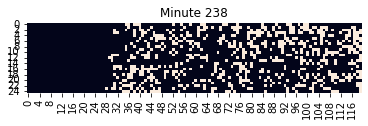

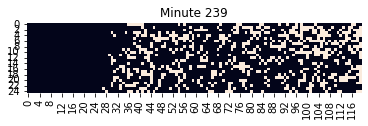

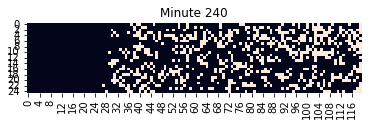

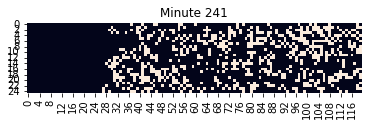

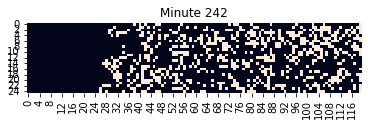

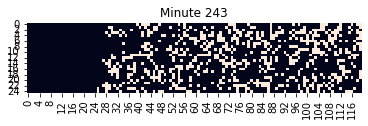

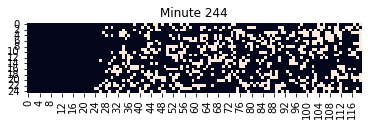

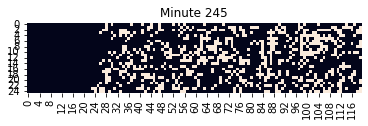

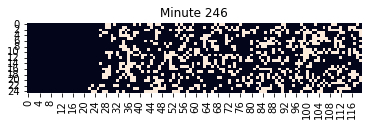

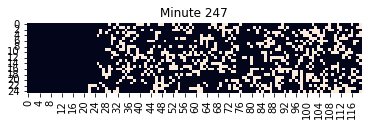

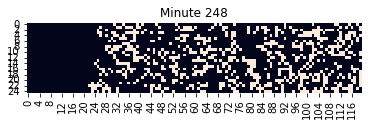

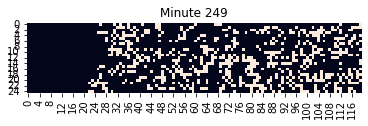

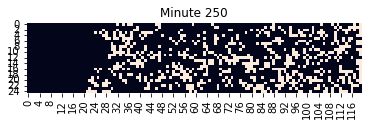

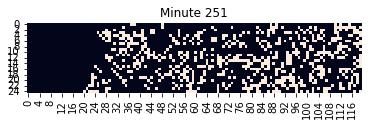

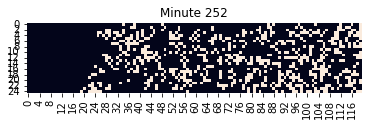

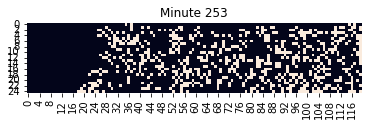

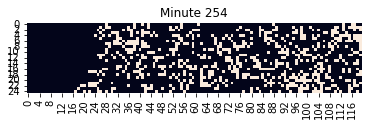

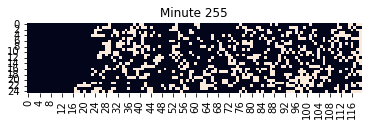

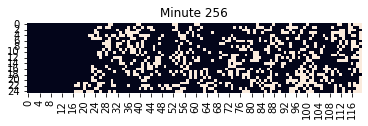

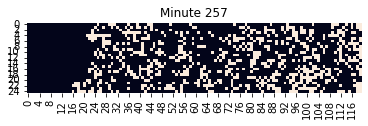

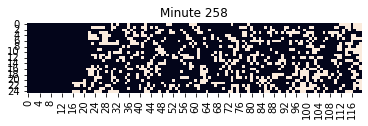

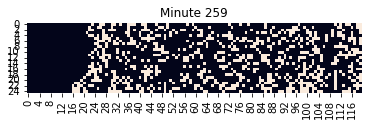

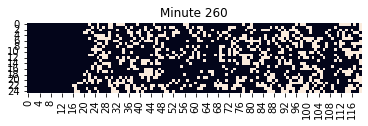

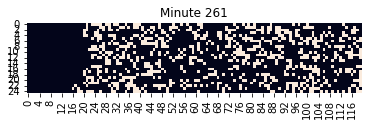

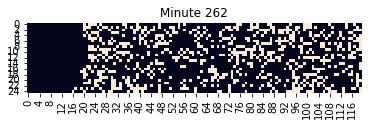

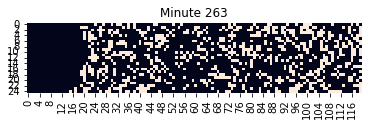

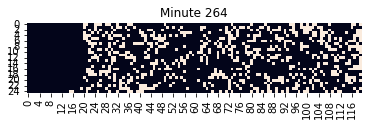

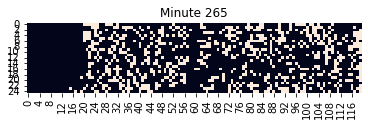

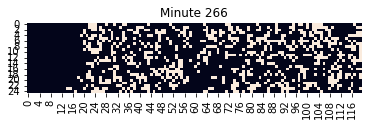

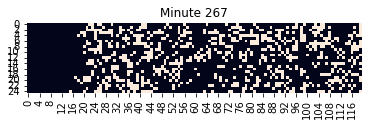

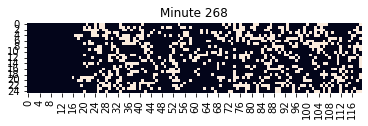

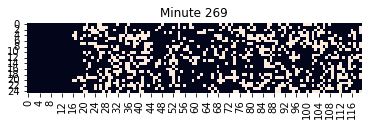

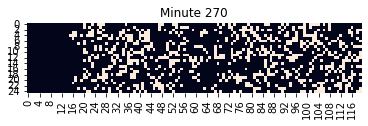

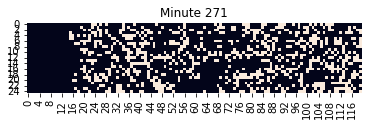

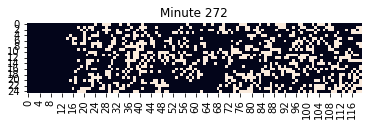

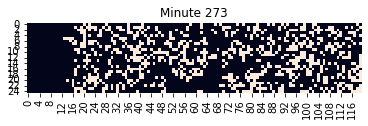

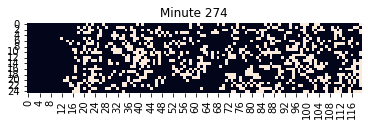

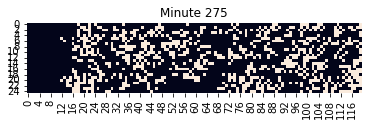

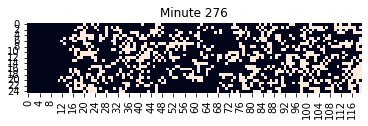

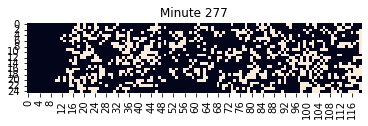

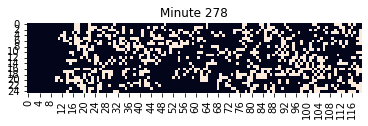

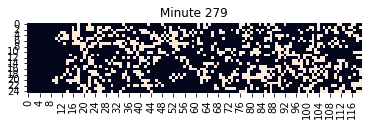

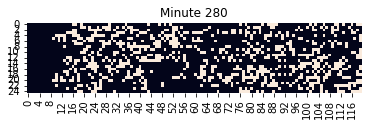

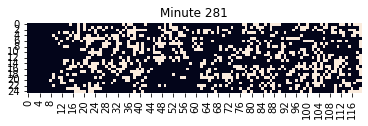

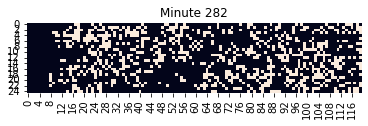

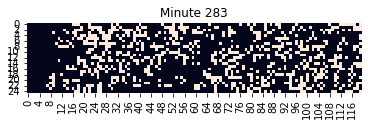

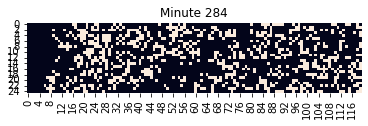

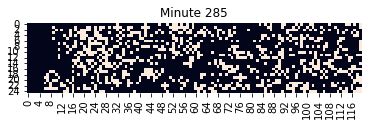

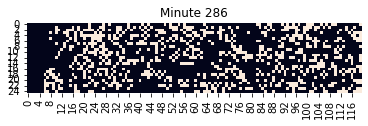

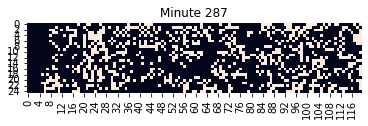

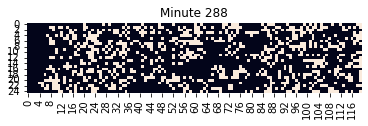

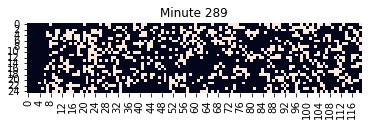

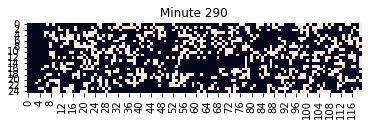

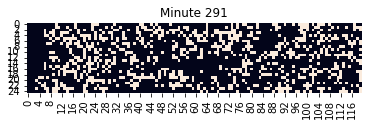

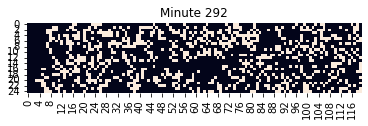

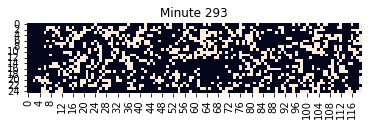

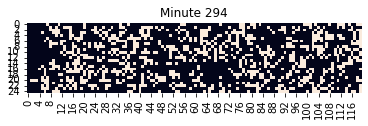

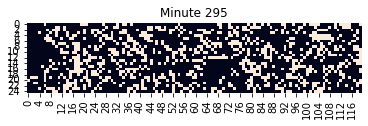

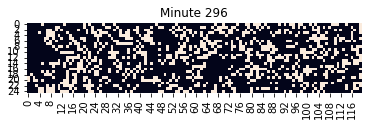

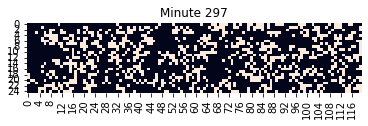

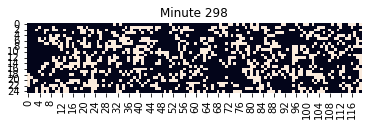

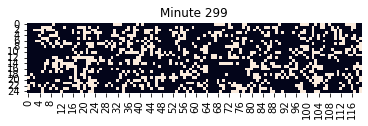

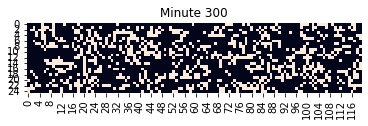

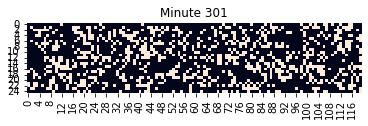

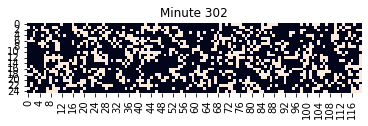

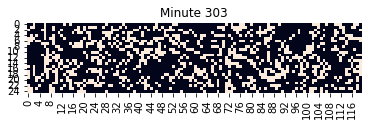

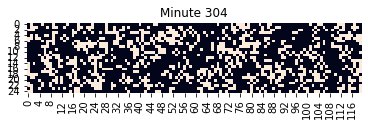

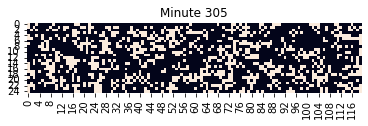

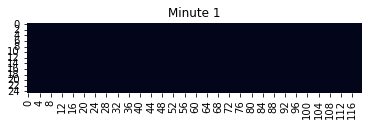

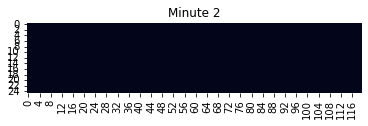

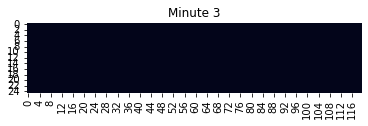

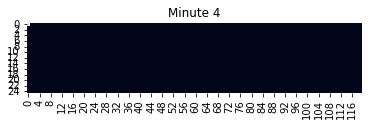

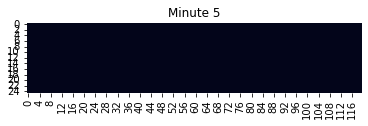

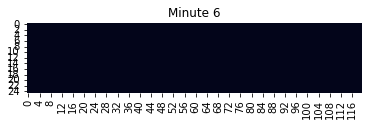

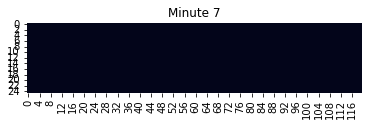

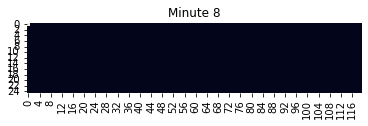

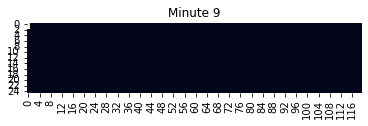

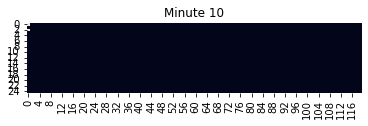

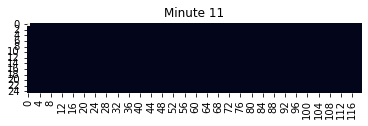

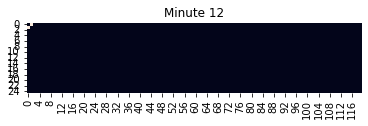

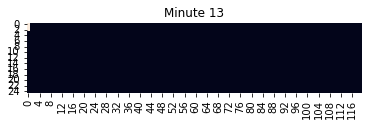

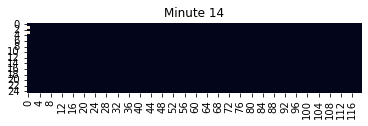

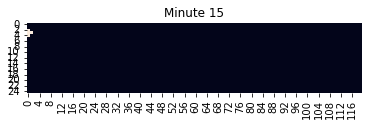

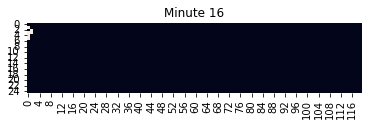

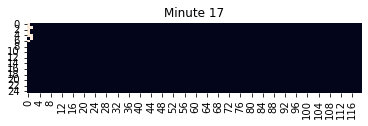

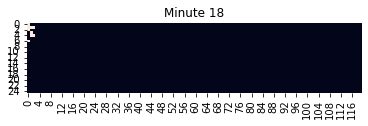

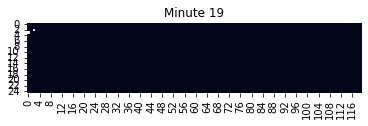

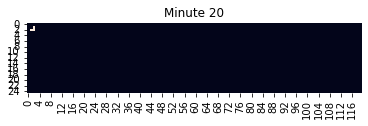

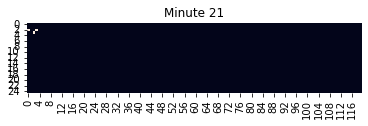

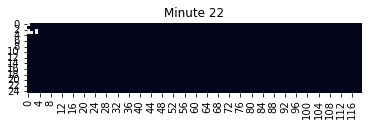

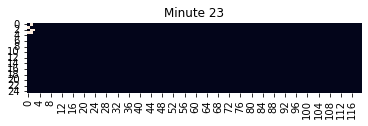

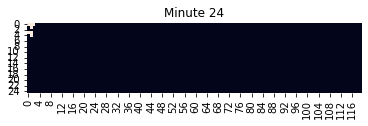

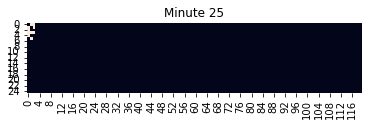

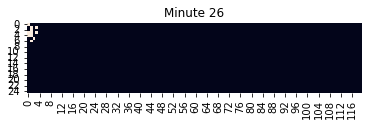

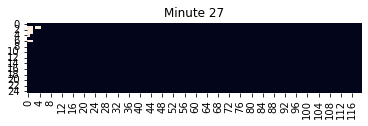

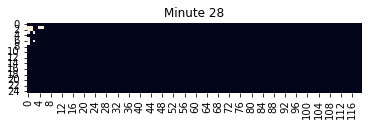

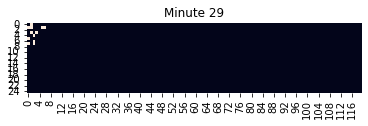

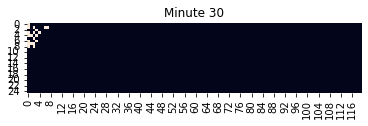

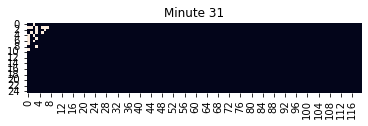

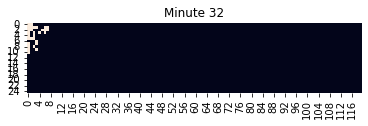

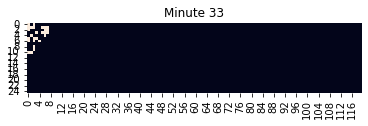

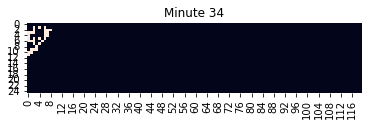

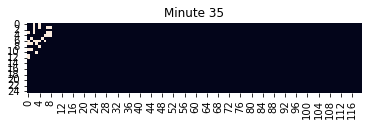

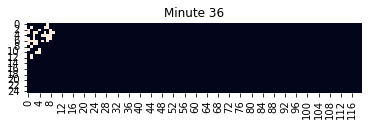

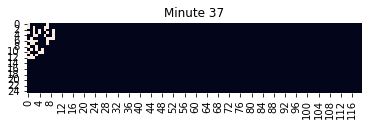

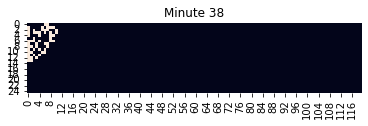

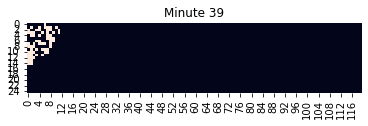

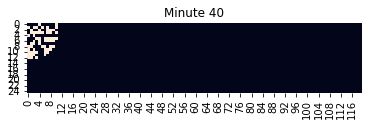

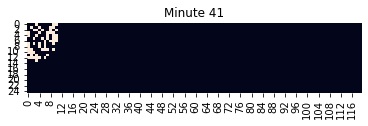

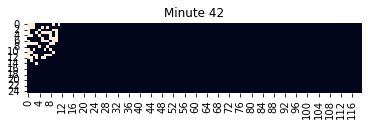

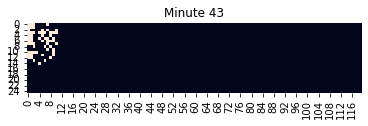

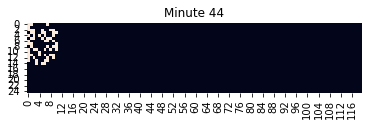

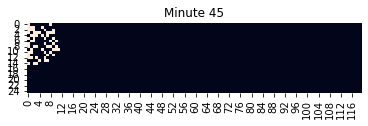

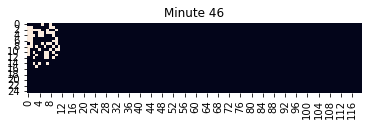

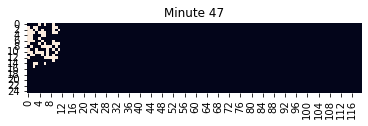

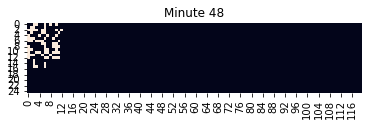

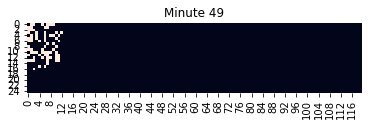

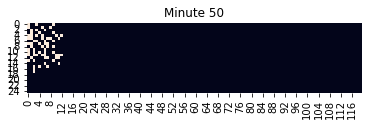

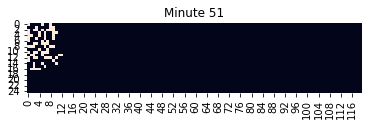

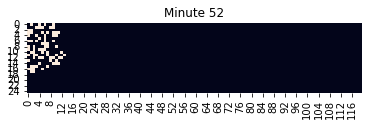

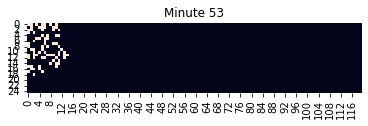

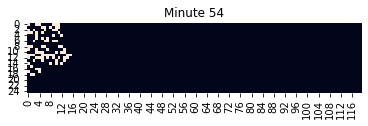

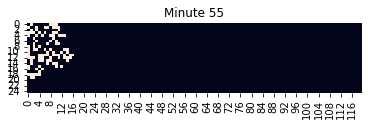

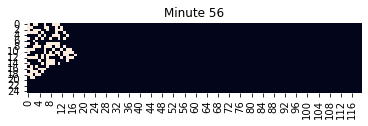

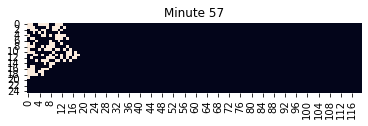

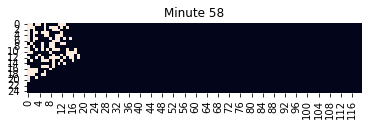

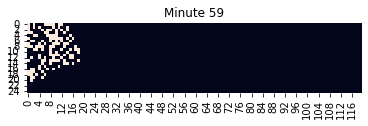

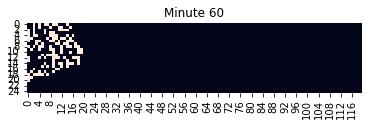

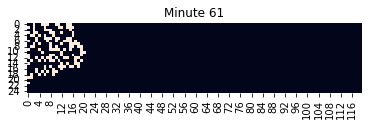

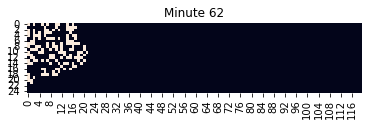

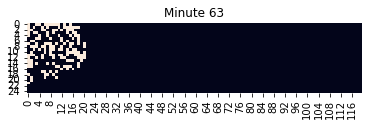

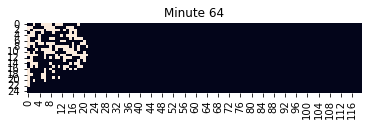

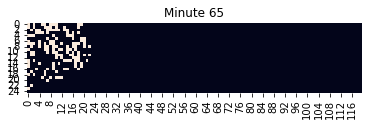

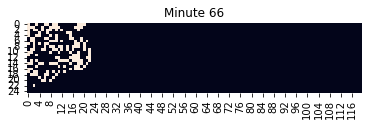

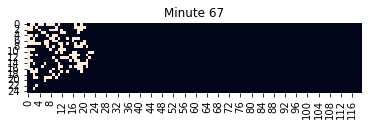

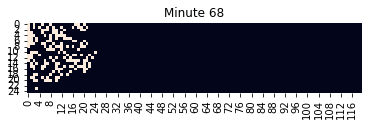

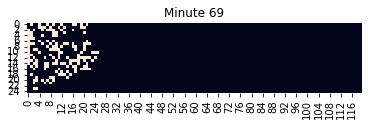

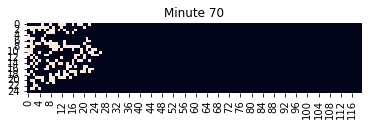

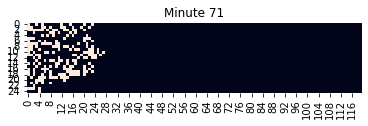

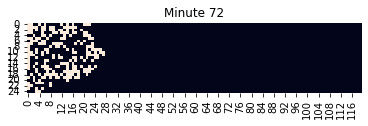

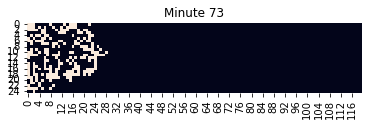

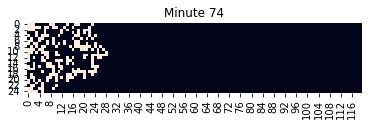

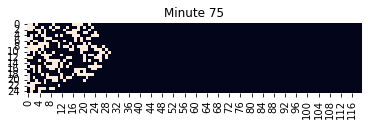

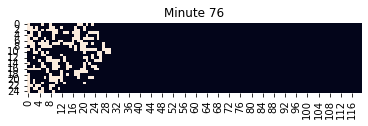

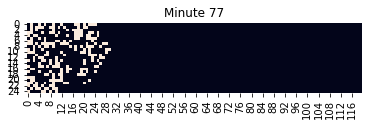

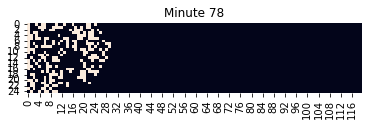

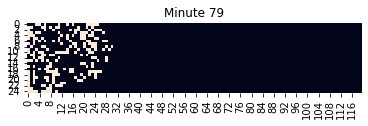

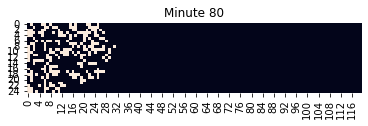

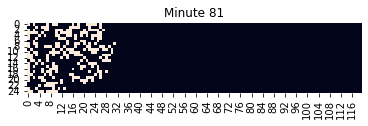

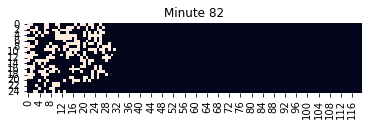

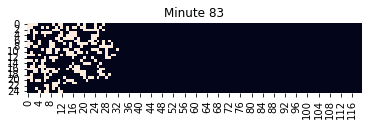

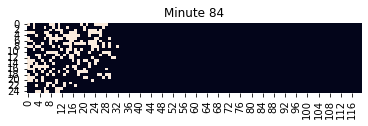

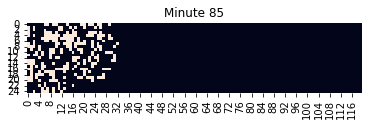

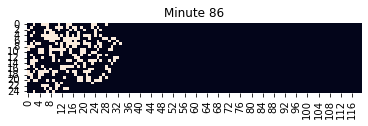

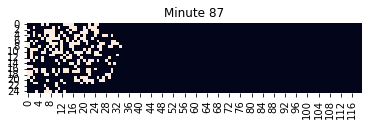

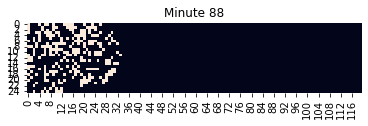

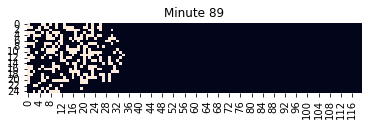

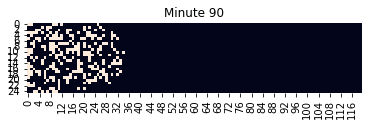

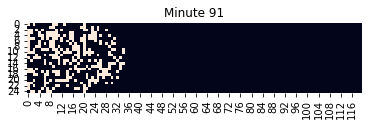

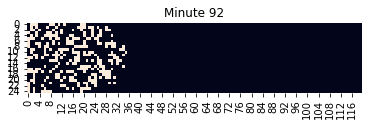

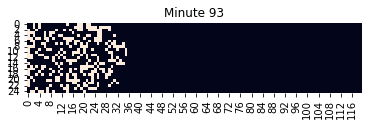

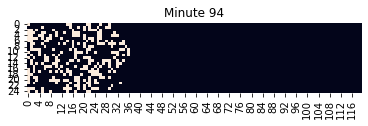

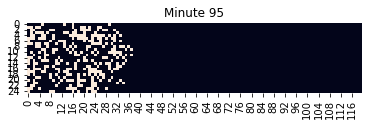

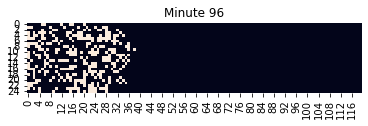

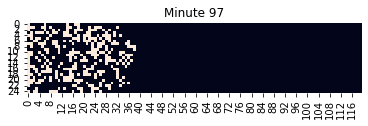

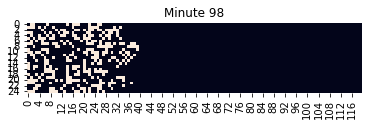

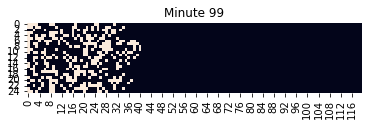

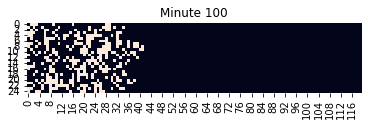

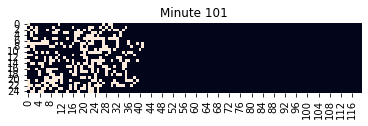

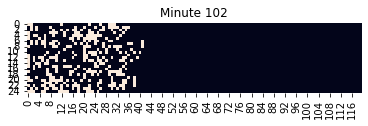

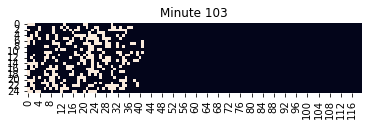

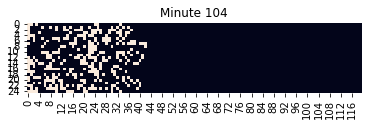

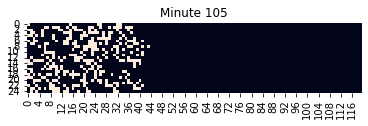

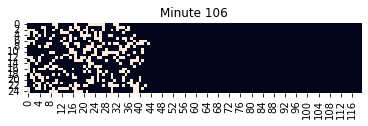

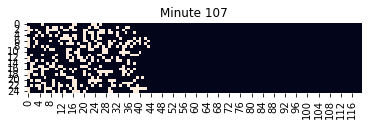

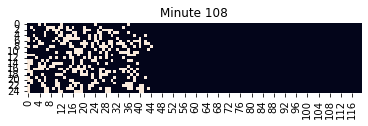

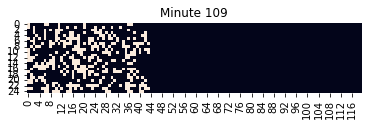

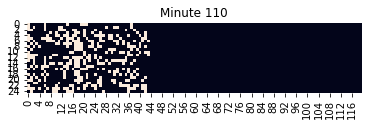

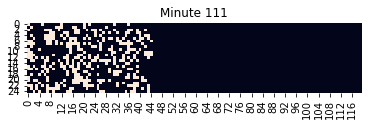

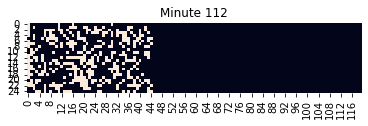

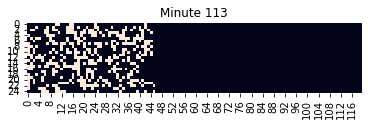

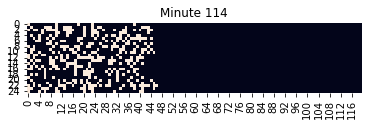

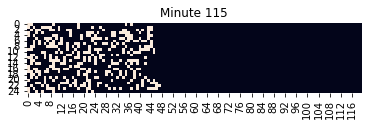

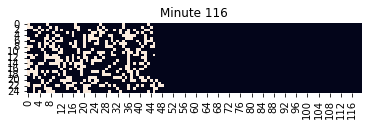

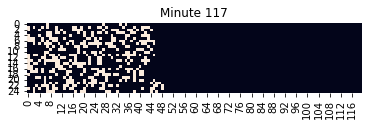

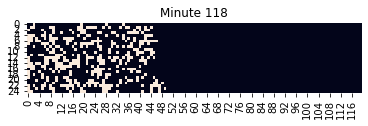

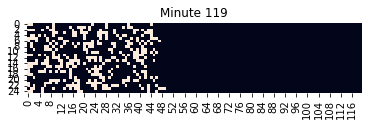

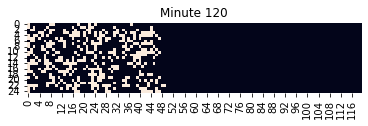

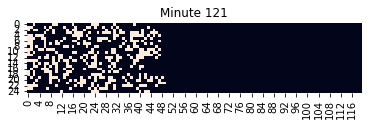

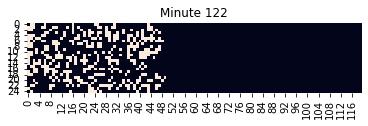

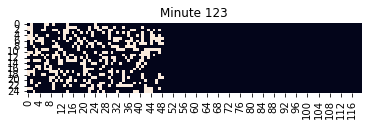

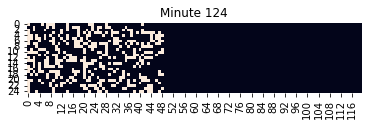

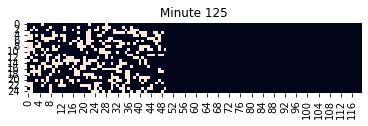

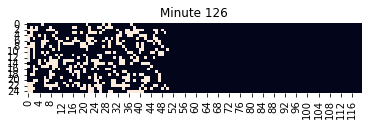

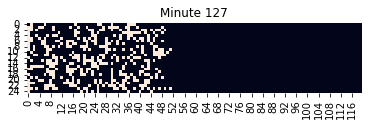

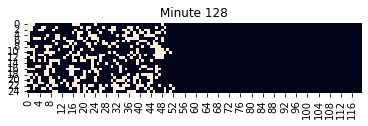

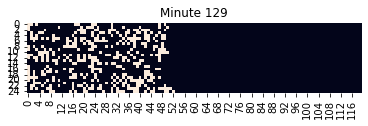

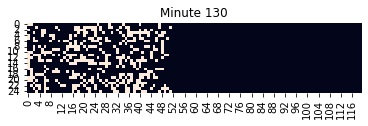

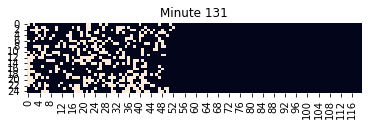

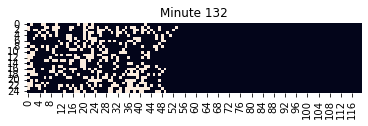

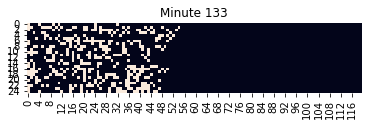

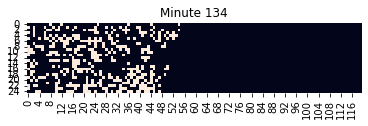

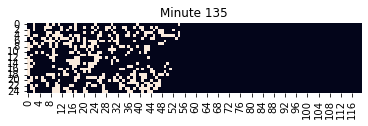

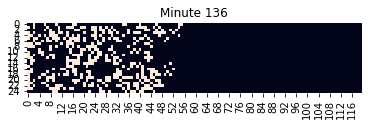

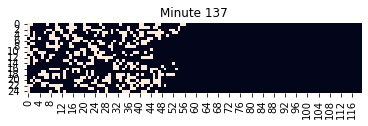

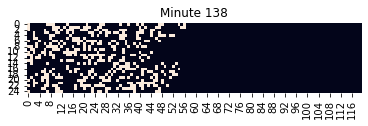

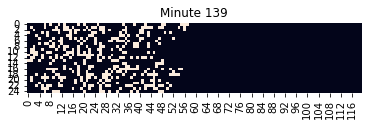

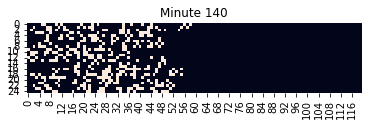

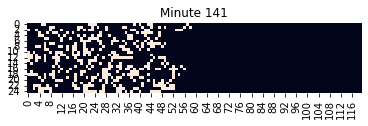

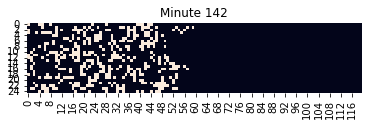

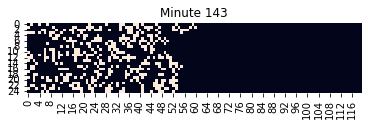

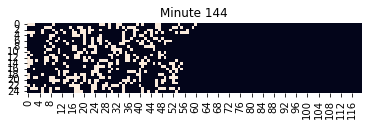

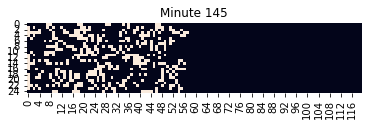

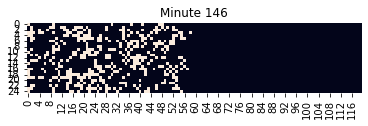

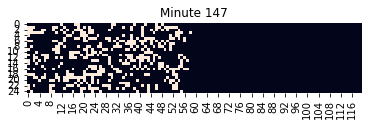

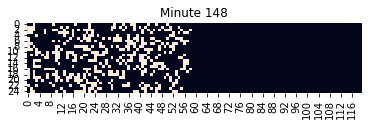

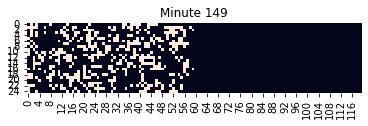

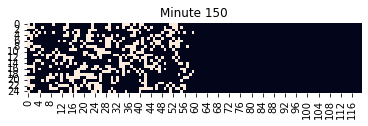

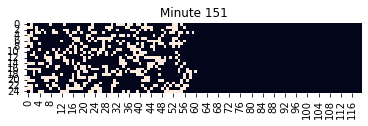

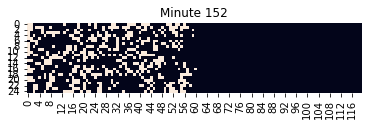

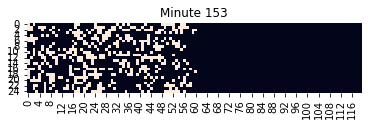

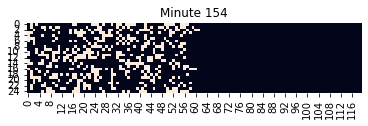

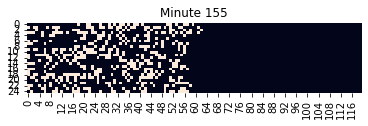

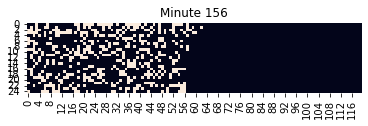

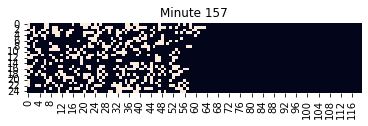

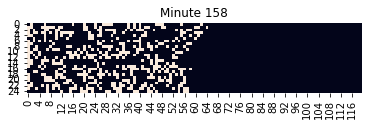

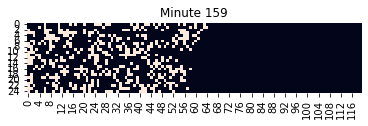

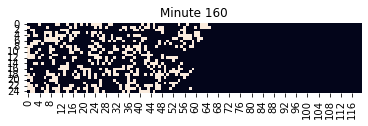

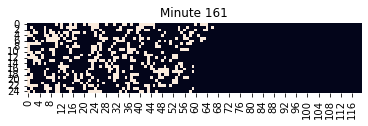

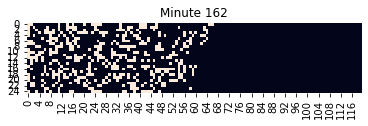

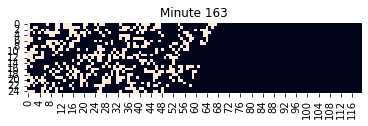

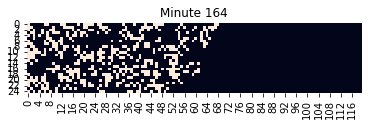

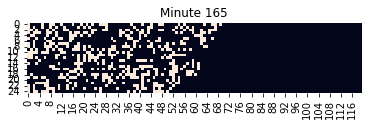

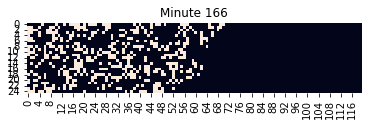

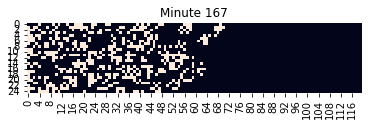

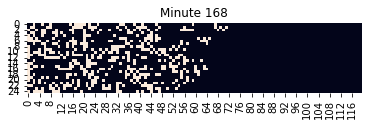

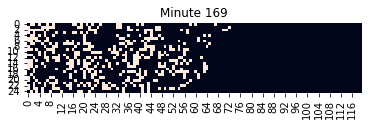

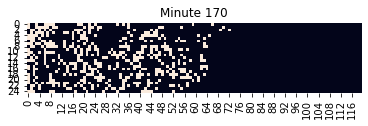

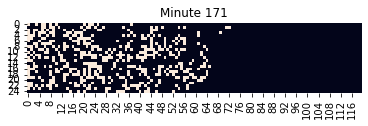

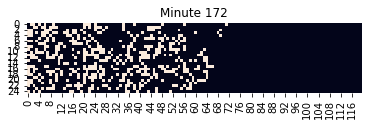

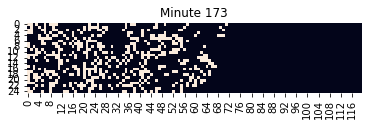

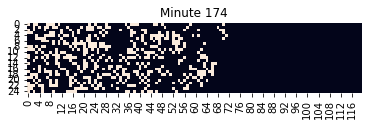

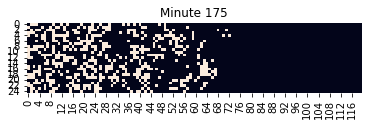

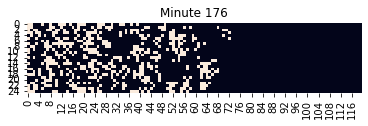

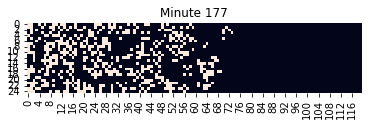

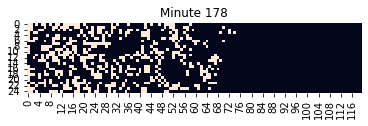

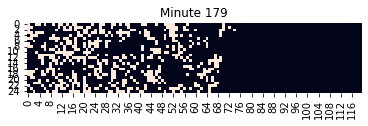

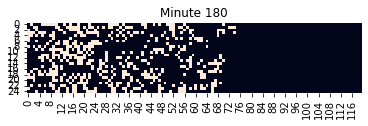

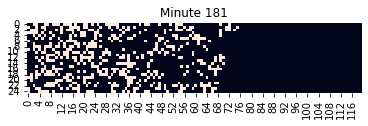

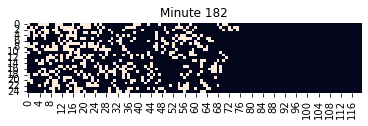

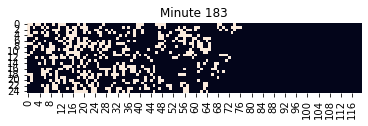

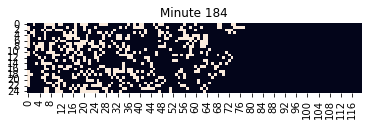

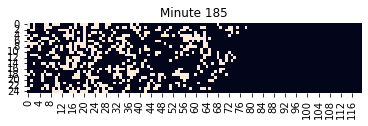

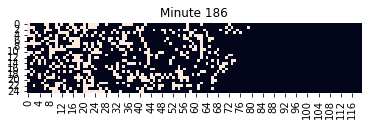

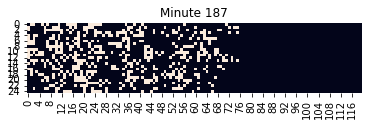

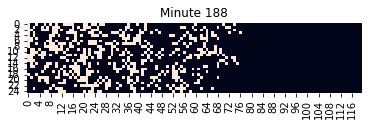

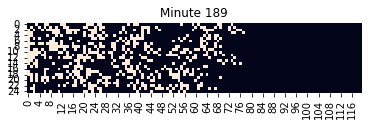

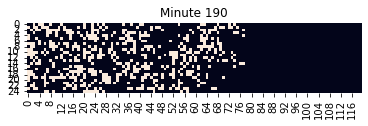

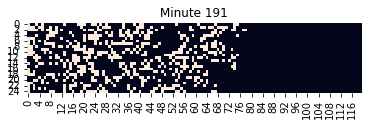

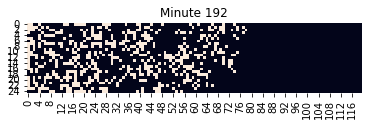

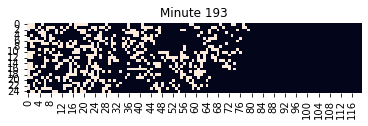

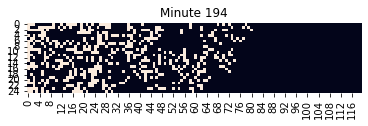

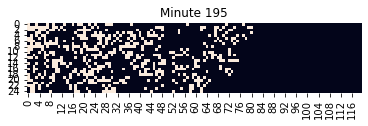

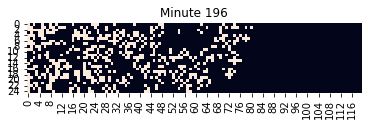

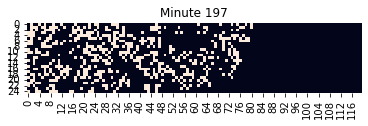

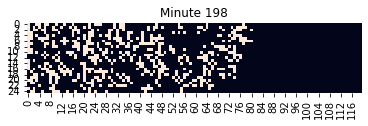

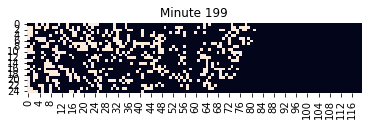

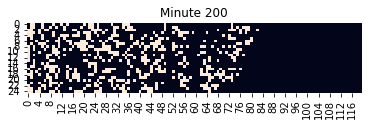

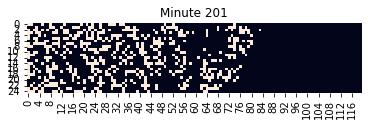

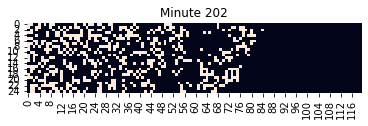

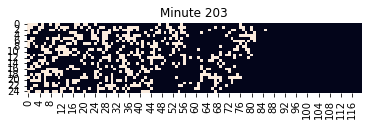

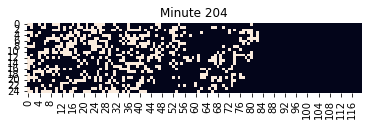

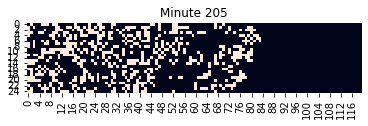

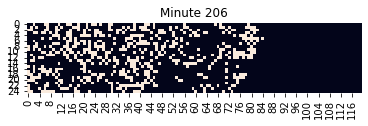

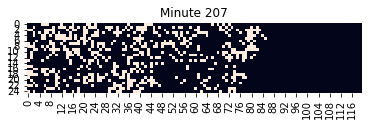

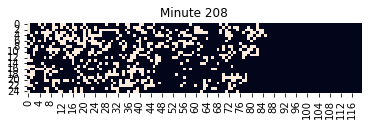

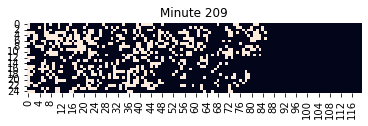

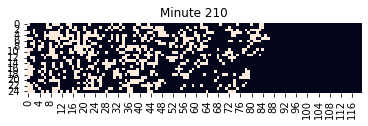

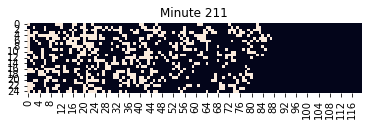

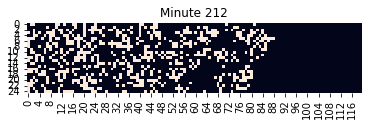

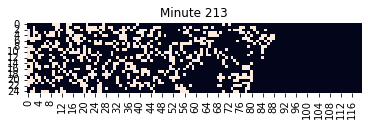

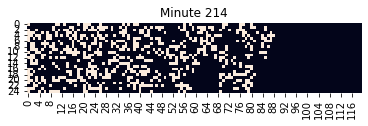

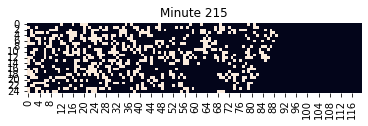

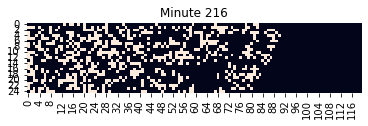

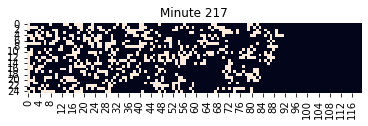

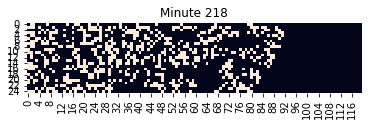

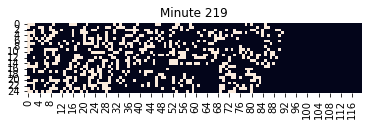

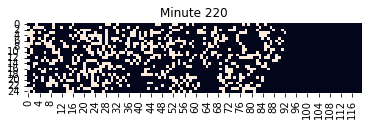

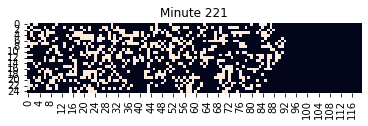

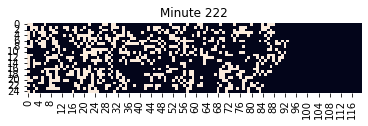

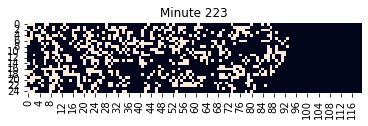

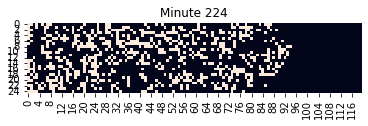

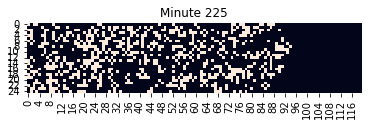

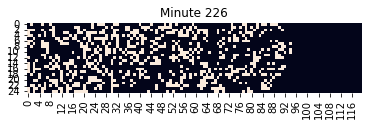

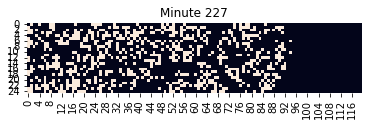

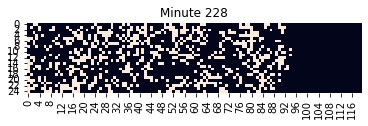

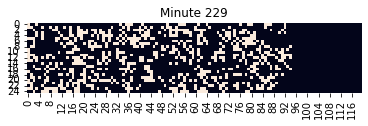

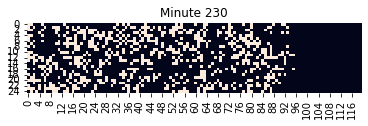

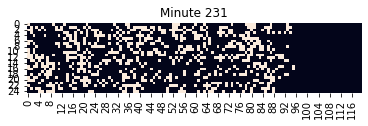

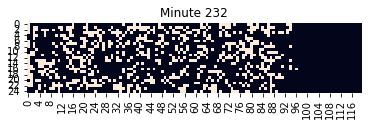

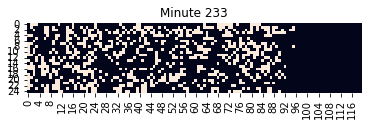

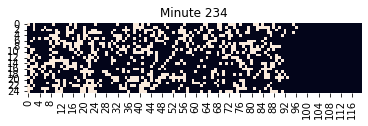

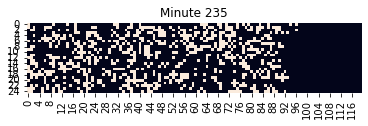

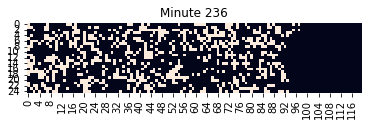

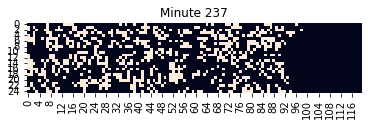

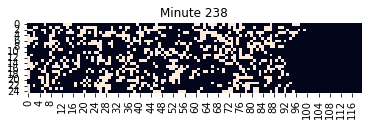

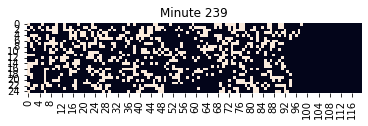

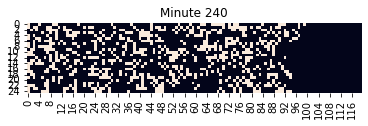

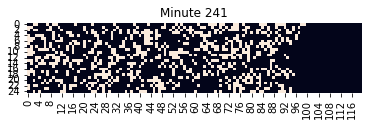

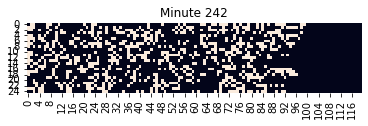

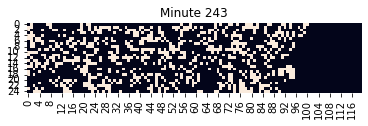

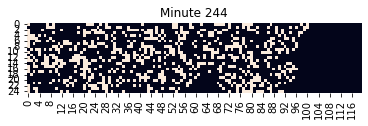

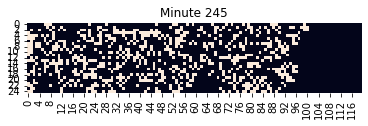

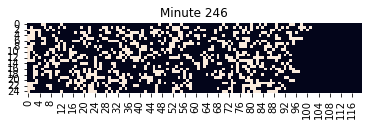

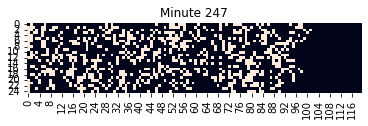

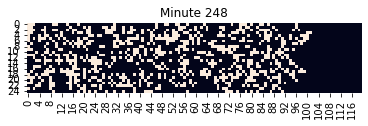

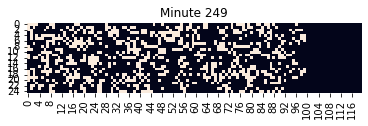

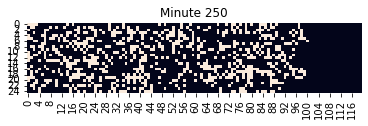

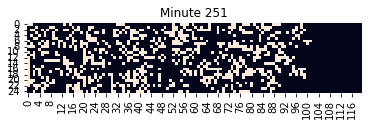

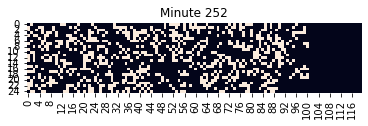

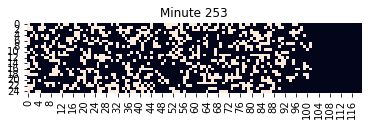

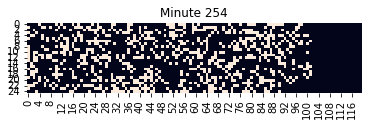

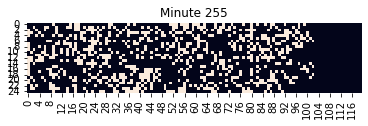

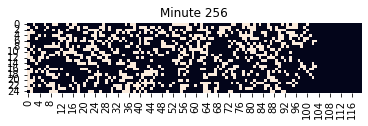

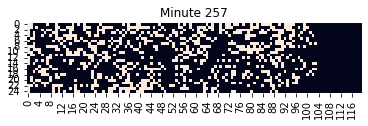

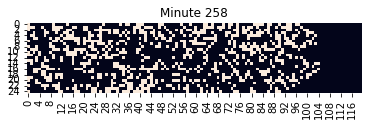

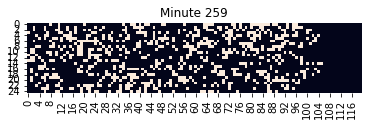

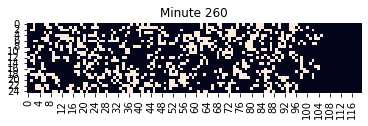

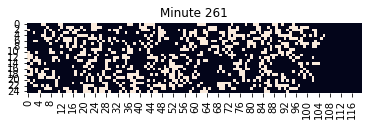

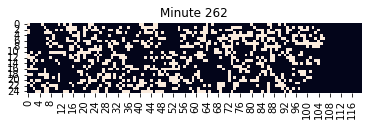

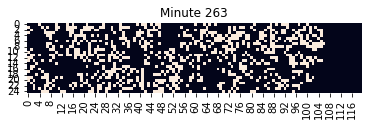

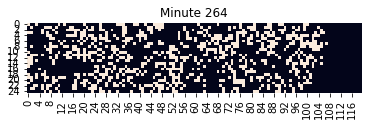

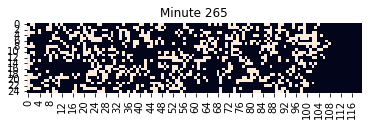

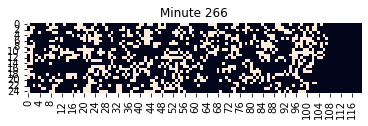

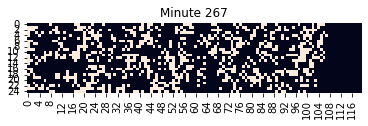

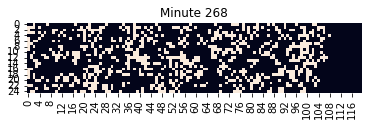

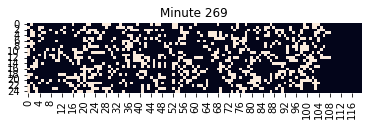

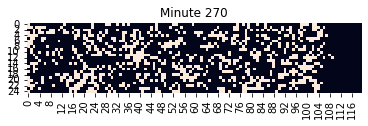

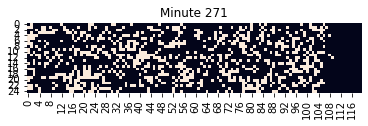

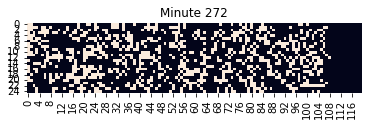

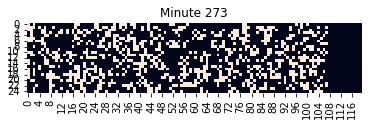

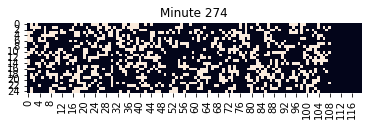

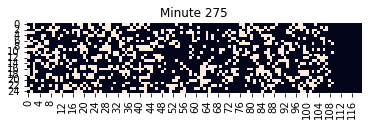

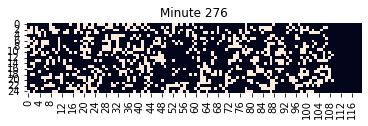

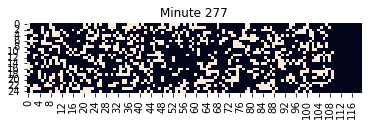

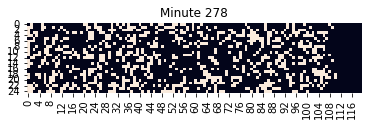

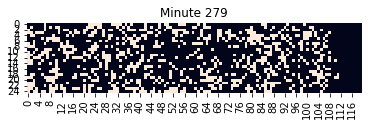

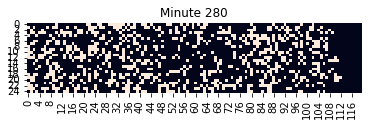

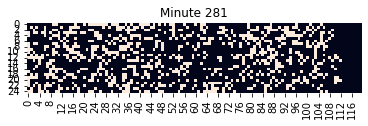

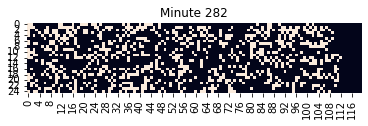

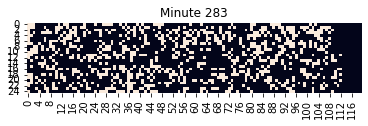

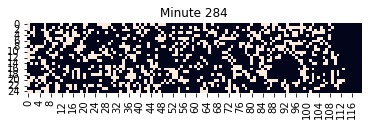

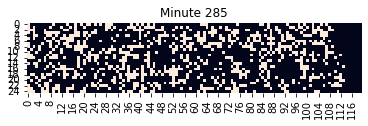

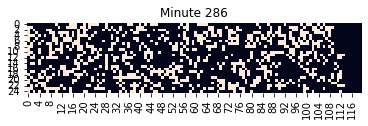

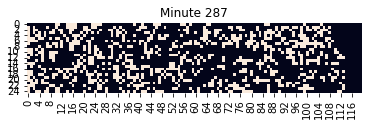

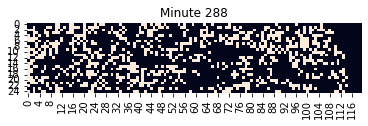

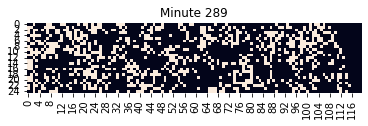

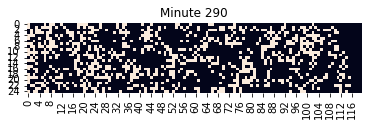

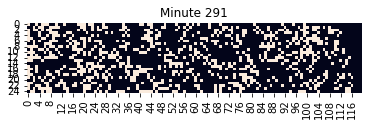

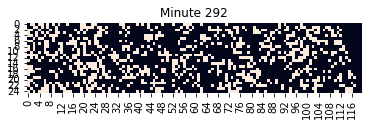

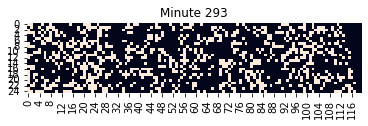

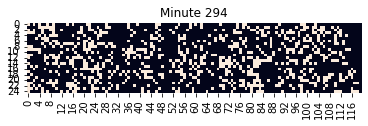

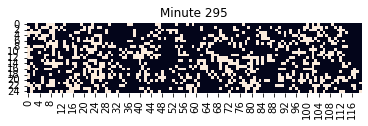

277 306 296 879


In [11]:
h = Storms(contents,verbose = True)
ha = h.time_through_storm(plots=True)
hb = h.backwards_time_through_storm(plots = True)
hc = h.time_through_storm(plots = True)
print(ha,hb,hc,ha+hb+hc)

##  Part II Notes

So for some reason I have an off by 2 error.  Am not going to bother trying to figure it out because it was consistent between both the description example and the contest data file.  So for the contest answer it's the 879 - 2